# Setup

## Import Libraries

In [1]:
from datasets import *
from train import *
from torchvision import datasets, transforms, models
from matplotlib.pyplot import figure
import cvxpy as cp

## Load Models

In [2]:
# model = models.efficientnet_b0(weights='DEFAULT').to('cuda')
# model64 = models.mobilenet_v3_small()
# model64.classifier[0] = torch.nn.Linear(576,1280)
# model64.classifier[3] = torch.nn.Linear(1280,1000)
# model64.load_state_dict(torch.load("best_batch_i162153.pth")['model_state_dict'])
model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda')
model64 = models.mobilenet_v3_large()
model64.load_state_dict(torch.load("best_modelsv3/best_batch_i1081020.pth")['model_state_dict'])
model64.to('cuda')
model.eval()
model64.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

## Load Validation Sets

### Clean Validation Sets

In [3]:
clean_val_loader = load_imagenet(128,1234,False)
clean_val_loader64 = load_imagenet64(128,1234,False)

### Corrupted Validation Sets

In [4]:
corruptions = ['gaussian_noise','impulse_noise','shot_noise','defocus_blur','glass_blur','motion_blur','zoom_blur','snow','frost','fog','brightness','contrast','elastic_transform','jpeg_compression','pixelate']

corr_val_loaders = []
corr_val_loaders64 = []
for corr in corruptions:
    corr_val_loaders.append(load_imagenetc_val(128,1234,corr,severity=1))
    corr_val_loaders64.append(load_imagenetc64_val(128,1234,corr,severity=1))

# Baseline Accuracies

## test clean validation sets

In [92]:
acc_clean = validate(model,clean_val_loader,'cuda')
acc64_clean = validate(model64,clean_val_loader64,'cuda')

100%|██████████| 391/391 [00:15<00:00, 25.95it/s]


## test corrupted validation sets

In [93]:
acc_corr = []
acc_corr64 = []

for i,corr_set in enumerate(corr_val_loaders):
    acc_corr.append(validate(model,corr_val_loaders[i],'cuda')[0])
    acc_corr64.append(validate(model64,corr_val_loaders64[i],'cuda')[0])

100%|██████████| 391/391 [00:15<00:00, 26.06it/s]


## save results to csv

In [94]:
import pandas as pd
df = pd.DataFrame(columns=corruptions)
df.loc[0] = acc_corr
df.loc[1] = acc_corr64
df.insert(0, "Model", ['224x224', '64x64'])
df.insert(1,'Clean Acc.',[acc_clean,acc64_clean])
df.insert(2,'Avg Corr. Acc.',[sum(acc_corr)/len(acc_corr),sum(acc_corr64)/len(acc_corr64)])
df.to_csv("accuracy results_128_1.csv")

# Get confidence Scores

## clean confidence scores

### function to get confidence bins and distribution

In [33]:
# pass in validation set and model
def get_conf_cal(data_loader, model):
    # store the confidence and prediction result for each sample
    confidences = torch.zeros(len(data_loader.dataset))
    accuracies = torch.zeros(len(data_loader.dataset))

    # get the confidence and predictions result for each sample
    idx = 0
    with torch.no_grad():
        for (img_batch, label_batch) in tqdm(data_loader):
            img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')

            # save the next batch of results based on start and end idxs
            start = idx*data_loader.batch_size
            end = start + len(label_batch)

            # get the model's softmax output and class predictions, then get a mask of correct predictions
            conf, pred = torch.max(F.softmax(model(img_batch), dim=1), 1)
            acc = pred.eq(label_batch)
            conf,pred,acc = conf.to('cpu'),pred.to('cpu'),acc.to('cpu')

            confidences[start:end] = conf
            accuracies[start:end] = acc
            idx +=  1

    # initialize the calibration bins
    n_bins = 10
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accs = [0.0]*n_bins
    avg_confs = [0.0]*n_bins
    confs_hist = [0.0]*n_bins
    total_avg_conf = 0.0
    total_acc = 0.0

    i = 0
    # iterate over bins
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # mask to determine which confidence scores go in this bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())

        # from the mask determine what percent of the confidence scores are in this bin
        prop_in_bin = in_bin.float().mean()

        confs_hist[i] = len(confidences[in_bin])/len(data_loader.dataset)

        # if the bin is not empty
        if prop_in_bin.item() > 0:
            # calculate accuracy of the bin using the mask of correct predictions
            accuracy_in_bin = accuracies[in_bin].float().mean()

            # get the average confidence score of items in this bin
            avg_confidence_in_bin = confidences[in_bin].mean()
            accs[i] = accuracy_in_bin
            avg_confs[i] = avg_confidence_in_bin.detach()
        i+=1

    total_avg_conf = sum([avg_confs[i]*confs_hist[i] for i in range(len(confs_hist))]) # weight by confidence histogram
    total_acc = sum([accs[i]*confs_hist[i] for i in range(len(confs_hist))])
    
    # return the accuracy of all bins and the average confidence score of the bins
    return accs, avg_confs, confs_hist, total_avg_conf, total_acc

get the confidence scores for both 224 and 64

In [34]:
accs_cal, confs_cal, confs_hist, total_avg_conf, total_acc = get_conf_cal(clean_val_loader,model)
accs64_cal, confs64_cal, confs_hist64, total_avg_conf64, total_acc64 = get_conf_cal(clean_val_loader64,model64)

100%|██████████| 391/391 [00:16<00:00, 24.19it/s]


conf hist for 224

(-2.5, 47.5)

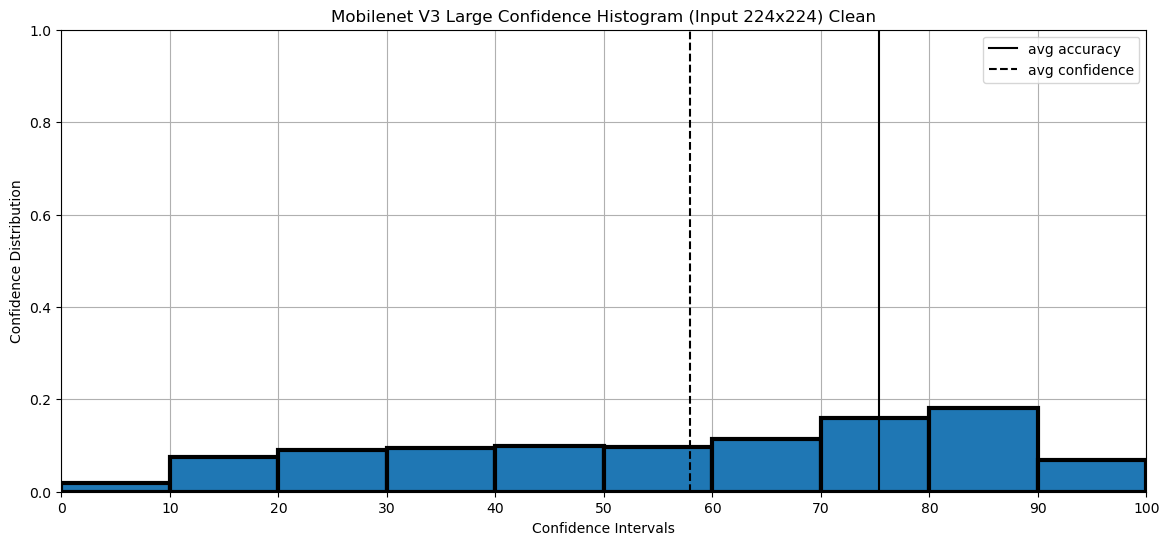

In [35]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.rc('axes', axisbelow=True)
plt.grid()
plt.bar(xpos[:-1],confs_hist,width=5,edgecolor = "black",linewidth=3)
plt.xticks(xtickpos, bars)
plt.axvline(x = total_acc*50-2.5, color = 'k', label = 'avg accuracy')
plt.axvline(x = total_avg_conf*50-2.5, color = 'k', label = 'avg confidence',linestyle="--")
plt.legend()
plt.title('Mobilenet V3 Large Confidence Histogram (Input 224x224) Clean')
plt.xlabel("Confidence Intervals")
plt.ylabel("Confidence Distribution")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])

reliability plot for 224

[tensor(0.0550), tensor(0.1247), tensor(0.1759), tensor(0.2159), tensor(0.2207), tensor(0.2373), tensor(0.2229), tensor(0.1905), tensor(0.1280), tensor(0.0457)]
[tensor(0.0769), tensor(0.1528), tensor(0.2508), tensor(0.3508), tensor(0.4500), tensor(0.5506), tensor(0.6525), tensor(0.7538), tensor(0.8466), tensor(0.9344)]


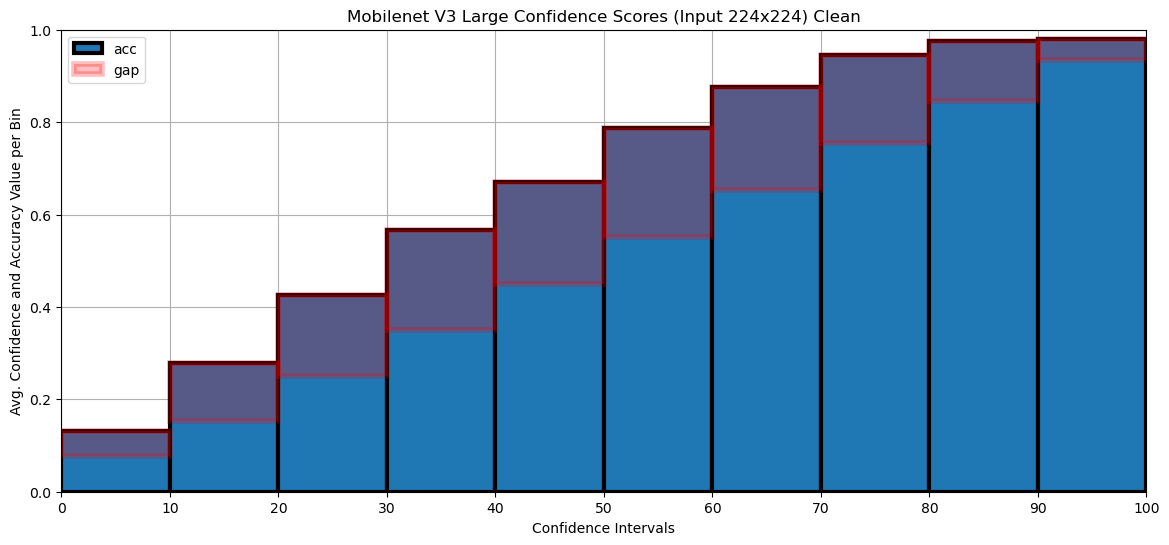

In [36]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.bar(xpos[:-1],accs_cal,label="acc",width=5,edgecolor='black',linewidth=3)
plt.xticks(xtickpos, bars)
bot = []
top = []
for i,c in enumerate(confs_cal):
    if c > accs_cal[i]:
        bot.append(accs_cal[i])
        top.append(c-accs_cal[i])
    else:
        bot.append(c)
        top.append(accs_cal[i]-c)
print(top)
print(bot)
plt.bar(xpos[:-1],top,label="gap",width=5,edgecolor='red',bottom=bot,color='red',alpha=0.25,linewidth=4)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 224x224) Clean')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])
plt.grid()

In [37]:
print("ECE:",sum([abs(accs_cal[i] - confs_cal[i])*confs_hist[i] for i in range(len(confs_cal))]))

ECE: tensor(0.1738)


conf hist for 64

(-2.5, 47.5)

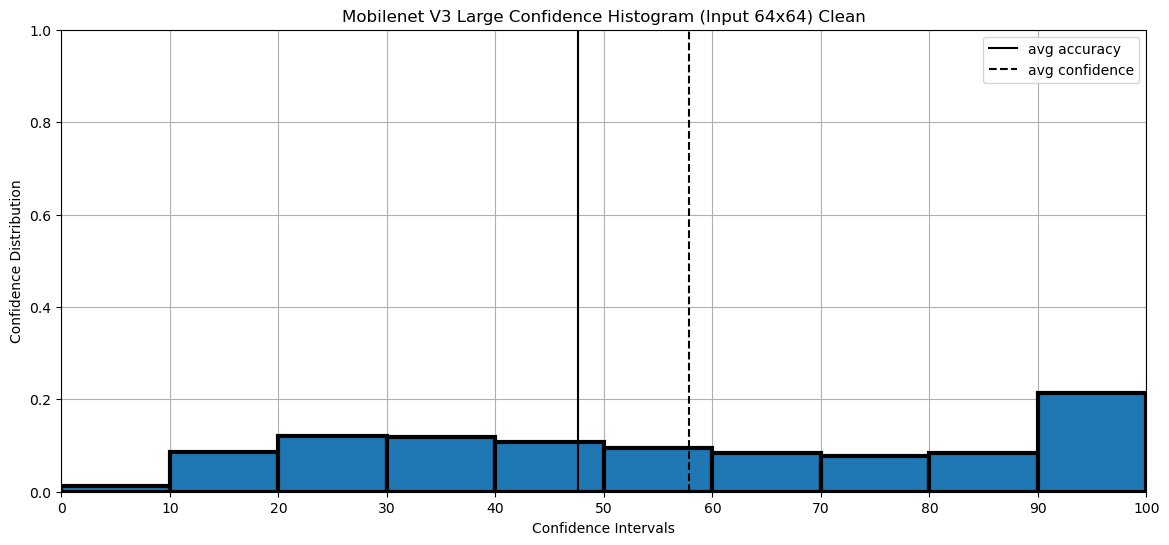

In [38]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.rc('axes', axisbelow=True)
plt.grid()
plt.bar(xpos[:-1],confs_hist64,width=5,edgecolor = "black",linewidth=3)
plt.xticks(xtickpos, bars)
plt.axvline(x = total_acc64*50-2.5, color = 'k', label = 'avg accuracy')
plt.axvline(x = total_avg_conf64*50-2.5, color = 'k', label = 'avg confidence',linestyle="--")
plt.legend()
plt.title('Mobilenet V3 Large Confidence Histogram (Input 64x64) Clean')
plt.xlabel("Confidence Intervals")
plt.ylabel("Confidence Distribution")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])

reliability plot for 64

[tensor(0.0273), tensor(0.0557), tensor(0.0825), tensor(0.1085), tensor(0.1101), tensor(0.1366), tensor(0.1562), tensor(0.1568), tensor(0.1375), tensor(0.0586)]
[tensor(0.0548), tensor(0.1010), tensor(0.1688), tensor(0.2406), tensor(0.3385), tensor(0.4113), tensor(0.4934), tensor(0.5934), tensor(0.7146), tensor(0.9113)]


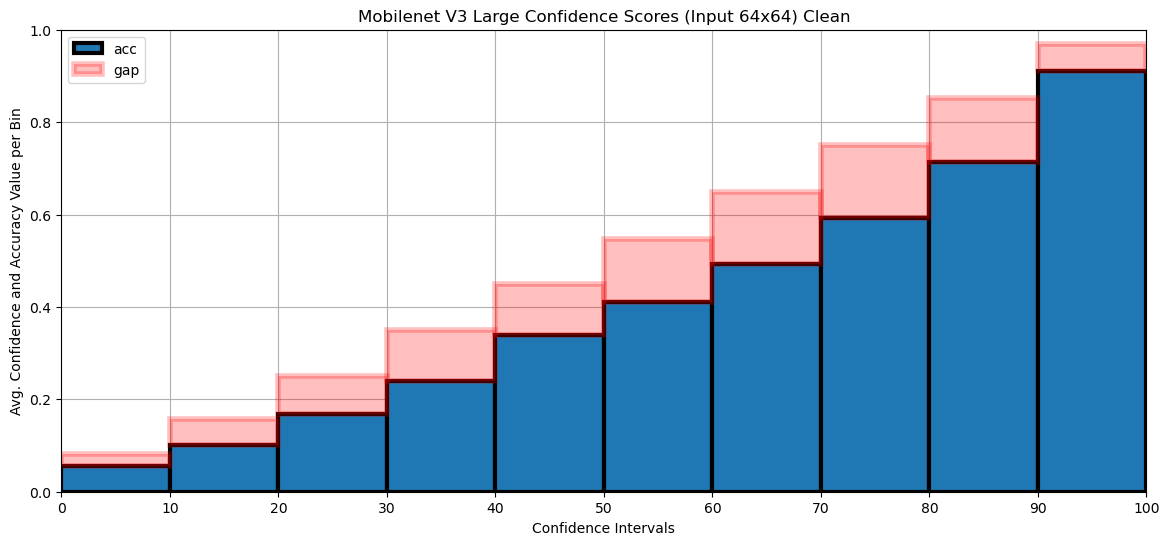

In [39]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.bar(xpos[:-1],accs64_cal,label="acc",width=5,edgecolor='black',linewidth=3)
plt.xticks(xtickpos, bars)
bot = []
top = []
for i,c in enumerate(confs64_cal):
    if c > accs64_cal[i]:
        bot.append(accs64_cal[i])
        top.append(c-accs64_cal[i])
    else:
        bot.append(c)
        top.append(accs64_cal[i]-c)
print(top)
print(bot)
plt.bar(xpos[:-1],top,label="gap",width=5,edgecolor='red',bottom=bot,color='red',alpha=0.25,linewidth=4)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 64x64) Clean')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])
plt.grid()

In [40]:
print("ECE:",sum([abs(accs64_cal[i] - confs64_cal[i])*confs_hist64[i] for i in range(len(confs64_cal))]))

ECE: tensor(0.1022)


## Corrupted Confidence Scores

### function to get scores for all corruptions

In [41]:
# pass in validation sets and model
def get_conf_cal_corr(data_loaders, model):
    # store confidences and prediction results over all validation sets
    confidences = torch.zeros(len(data_loaders[0].dataset)*len(data_loaders))
    accuracies = torch.zeros(len(data_loaders[0].dataset)*len(data_loaders))
    print(len(confidences))

    # iterate over all validation sets
    with torch.no_grad():
        for dl_idx, data_loader in enumerate(data_loaders):
            print(corruptions[dl_idx])
            idx = 0
            for (img_batch, label_batch) in tqdm(data_loader):
                img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')

                start = dl_idx*len(data_loader.dataset) + idx*data_loader.batch_size
                end = start + len(label_batch)

                # get the model's softmax output and class predictions, then get a mask of correct predictions
                conf, pred = torch.max(F.softmax(model(img_batch), dim=1), 1)
                acc = pred.eq(label_batch)
                conf,pred,acc = conf.to('cpu'),pred.to('cpu'),acc.to('cpu')

                confidences[start:end] = conf
                accuracies[start:end] = acc

                idx +=  1

    # initialize the calibration bins
    n_bins = 10
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accs = [0.0]*n_bins
    avg_confs = [0.0]*n_bins
    confs_hist = [0.0]*n_bins
    total_avg_conf = 0.0
    total_acc = 0.0

    i = 0
    # iterate over bins
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # mask to determine which confidence scores go in this bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        print(in_bin,"/",len(in_bin))

        # from the mask determine what percent of the confidence scores are in this bin
        prop_in_bin = in_bin.float().mean()

        confs_hist[i] = len(confidences[in_bin])/(len(data_loader.dataset)*len(data_loaders))

        # if the bin is not empty
        if prop_in_bin.item() > 0:
            # calculate accuracy of the bin using the mask of correct predictions
            accuracy_in_bin = accuracies[in_bin].float().mean()

            # get the average confidence score of items in this bin
            avg_confidence_in_bin = confidences[in_bin].mean()
            accs[i] = accuracy_in_bin
            avg_confs[i] = avg_confidence_in_bin.detach()
        i+=1
        
    total_avg_conf = sum([avg_confs[i]*confs_hist[i] for i in range(len(confs_hist))]) # weight by confidence histogram
    total_acc = sum([accs[i]*confs_hist[i] for i in range(len(confs_hist))])
    
    # return the accuracy of all bins and the average confidence score of the bins
    return accs, avg_confs, confs_hist, total_avg_conf, total_acc

In [42]:
corr_accs_cal, corr_confs_cal, corr_confs_hist, corr_total_avg_conf, corr_total_acc  = get_conf_cal_corr(corr_val_loaders,model)
corr_accs64_cal, corr_confs64_cal,corr_confs_hist64, corr_total_avg_conf64, corr_total_acc64  = get_conf_cal_corr(corr_val_loaders64,model64)

750000
gaussian_noise


100%|██████████| 391/391 [00:25<00:00, 15.58it/s]


impulse_noise


100%|██████████| 391/391 [00:25<00:00, 15.44it/s]


shot_noise


100%|██████████| 391/391 [00:25<00:00, 15.46it/s]


defocus_blur


100%|██████████| 391/391 [00:22<00:00, 17.55it/s]


glass_blur


100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


motion_blur


100%|██████████| 391/391 [00:22<00:00, 17.32it/s]


zoom_blur


100%|██████████| 391/391 [00:22<00:00, 17.40it/s]


snow


100%|██████████| 391/391 [00:23<00:00, 16.35it/s]


frost


100%|██████████| 391/391 [00:23<00:00, 16.71it/s]


fog


100%|██████████| 391/391 [00:22<00:00, 17.31it/s]


brightness


100%|██████████| 391/391 [00:23<00:00, 16.86it/s]


contrast


100%|██████████| 391/391 [00:22<00:00, 17.38it/s]


elastic_transform


100%|██████████| 391/391 [00:22<00:00, 17.12it/s]


jpeg_compression


100%|██████████| 391/391 [00:21<00:00, 18.25it/s]


pixelate


100%|██████████| 391/391 [00:23<00:00, 16.96it/s]


tensor([False, False, False,  ..., False,  True, False]) / 750000
tensor([ True,  True, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ...,  True, False,  True]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False,  True,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
750000
gaussian_noise


100%|██████████| 391/391 [00:04<00:00, 84.87it/s]


impulse_noise


100%|██████████| 391/391 [00:04<00:00, 85.48it/s]


shot_noise


100%|██████████| 391/391 [00:04<00:00, 85.18it/s]


defocus_blur


100%|██████████| 391/391 [00:04<00:00, 87.68it/s]


glass_blur


100%|██████████| 391/391 [00:04<00:00, 85.72it/s]


motion_blur


100%|██████████| 391/391 [00:04<00:00, 87.34it/s]


zoom_blur


100%|██████████| 391/391 [00:04<00:00, 88.48it/s]


snow


100%|██████████| 391/391 [00:04<00:00, 85.96it/s]


frost


100%|██████████| 391/391 [00:04<00:00, 85.68it/s]


fog


100%|██████████| 391/391 [00:04<00:00, 87.43it/s]


brightness


100%|██████████| 391/391 [00:04<00:00, 84.69it/s]


contrast


100%|██████████| 391/391 [00:04<00:00, 86.09it/s]


elastic_transform


100%|██████████| 391/391 [00:04<00:00, 87.31it/s]


jpeg_compression


100%|██████████| 391/391 [00:04<00:00, 88.25it/s]


pixelate


100%|██████████| 391/391 [00:04<00:00, 87.86it/s]

tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([ True, False, False,  ..., False, False,  True]) / 750000
tensor([False, False, False,  ...,  True,  True, False]) / 750000
tensor([False,  True, False,  ..., False, False, False]) / 750000
tensor([False, False,  True,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000


corr hist for 224

(-2.5, 47.5)

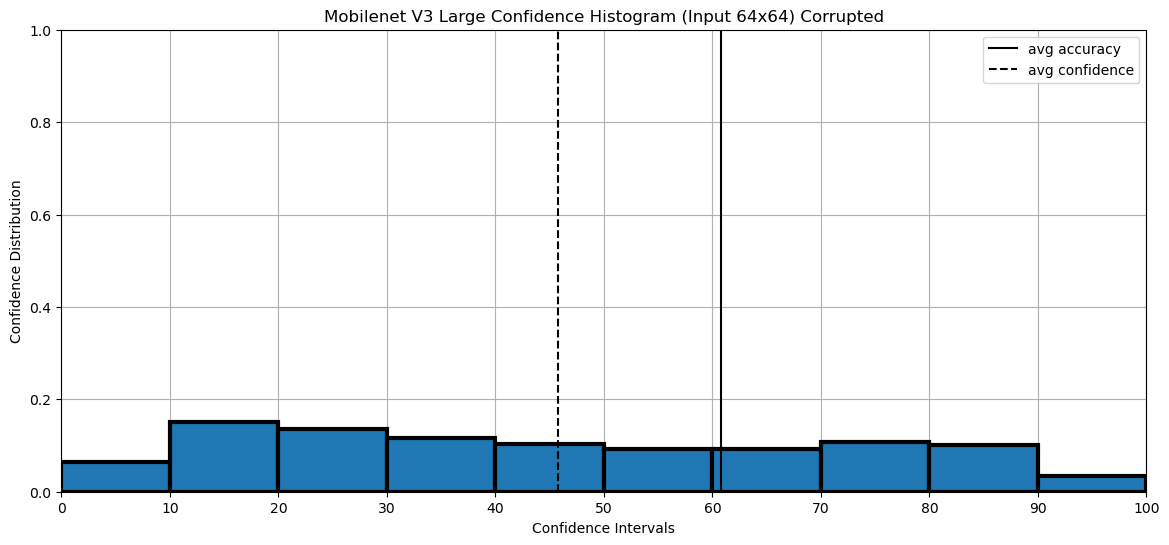

In [43]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.rc('axes', axisbelow=True)
plt.grid()
plt.bar(xpos[:-1],corr_confs_hist,width=5,edgecolor = "black",linewidth=3)
plt.xticks(xtickpos, bars)
plt.axvline(x = corr_total_acc*50-2.5, color = 'k', label = 'avg accuracy')
plt.axvline(x = corr_total_avg_conf*50-2.5, color = 'k', label = 'avg confidence',linestyle="--")
plt.legend()
plt.title('Mobilenet V3 Large Confidence Histogram (Input 64x64) Corrupted')
plt.xlabel("Confidence Intervals")
plt.ylabel("Confidence Distribution")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])

corr reliability for 224

[tensor(0.0546), tensor(0.0996), tensor(0.1464), tensor(0.1774), tensor(0.2000), tensor(0.2109), tensor(0.2046), tensor(0.1732), tensor(0.1183), tensor(0.0446)]
[tensor(0.0722), tensor(0.1499), tensor(0.2488), tensor(0.3491), tensor(0.4488), tensor(0.5497), tensor(0.6507), tensor(0.7515), tensor(0.8467), tensor(0.9319)]


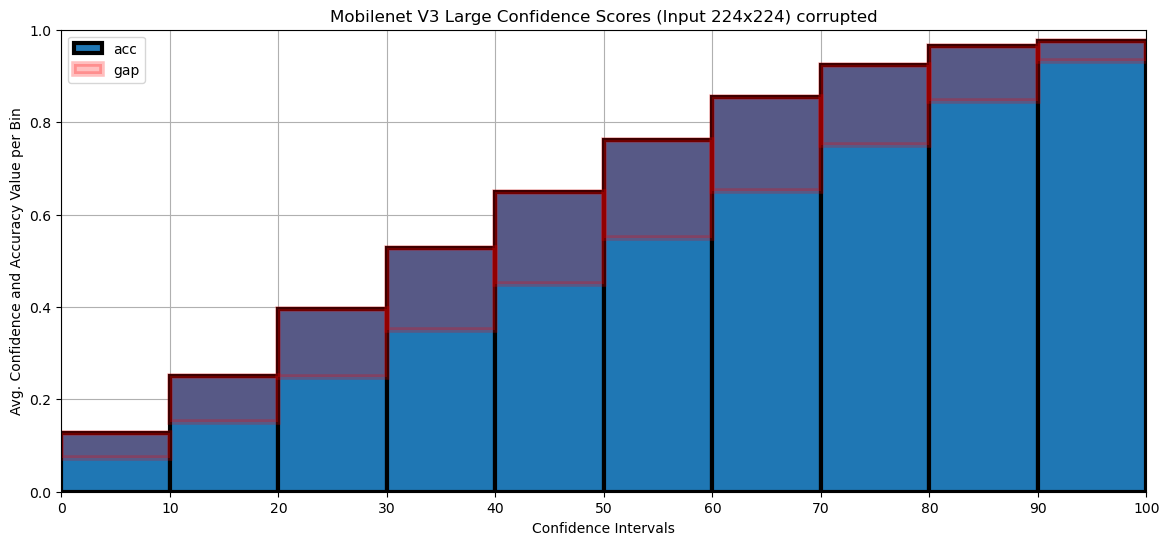

In [44]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.bar(xpos[:-1],corr_accs_cal,label="acc",width=5,edgecolor='black',linewidth=3)
plt.xticks(xtickpos, bars)
bot = []
top = []
for i,c in enumerate(corr_confs_cal):
    if c > corr_accs_cal[i]:
        bot.append(corr_accs_cal[i])
        top.append(c-corr_accs_cal[i])
    else:
        bot.append(c)
        top.append(corr_accs_cal[i]-c)
print(top)
print(bot)
plt.bar(xpos[:-1],top,label="gap",width=5,edgecolor='red',bottom=bot,color='red',alpha=0.25,linewidth=4)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 224x224) corrupted')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])
plt.grid()

In [45]:
print("ECE:",sum([abs(corr_accs_cal[i] - corr_confs_cal[i])*corr_confs_hist[i] for i in range(len(corr_confs_cal))]))

ECE: tensor(0.1505)


corr hist for 64

(-2.5, 47.5)

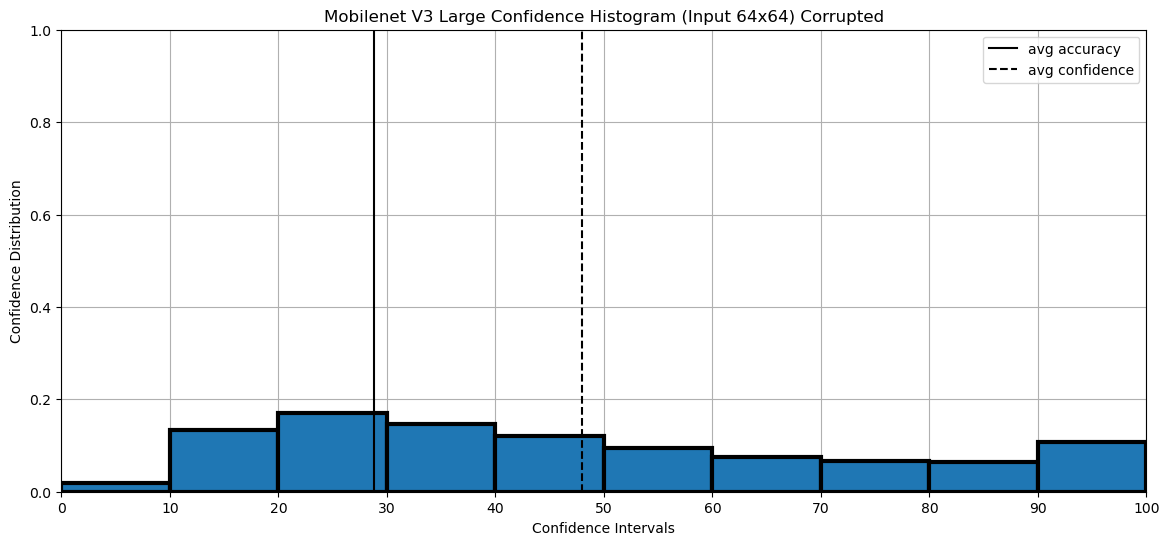

In [46]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.rc('axes', axisbelow=True)
plt.grid()
plt.bar(xpos[:-1],corr_confs_hist64,width=5,edgecolor = "black",linewidth=3)
plt.xticks(xtickpos, bars)
plt.axvline(x = corr_total_acc64*50-2.5, color = 'k', label = 'avg accuracy')
plt.axvline(x = corr_total_avg_conf64*50-2.5, color = 'k', label = 'avg confidence',linestyle="--")
plt.legend()
plt.title('Mobilenet V3 Large Confidence Histogram (Input 64x64) Corrupted')
plt.xlabel("Confidence Intervals")
plt.ylabel("Confidence Distribution")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])

corr reliability for 64

[tensor(0.0448), tensor(0.0865), tensor(0.1365), tensor(0.1841), tensor(0.2254), tensor(0.2608), tensor(0.2953), tensor(0.3096), tensor(0.2904), tensor(0.1407)]
[tensor(0.0373), tensor(0.0695), tensor(0.1131), tensor(0.1643), tensor(0.2229), tensor(0.2869), tensor(0.3533), tensor(0.4393), tensor(0.5598), tensor(0.8228)]


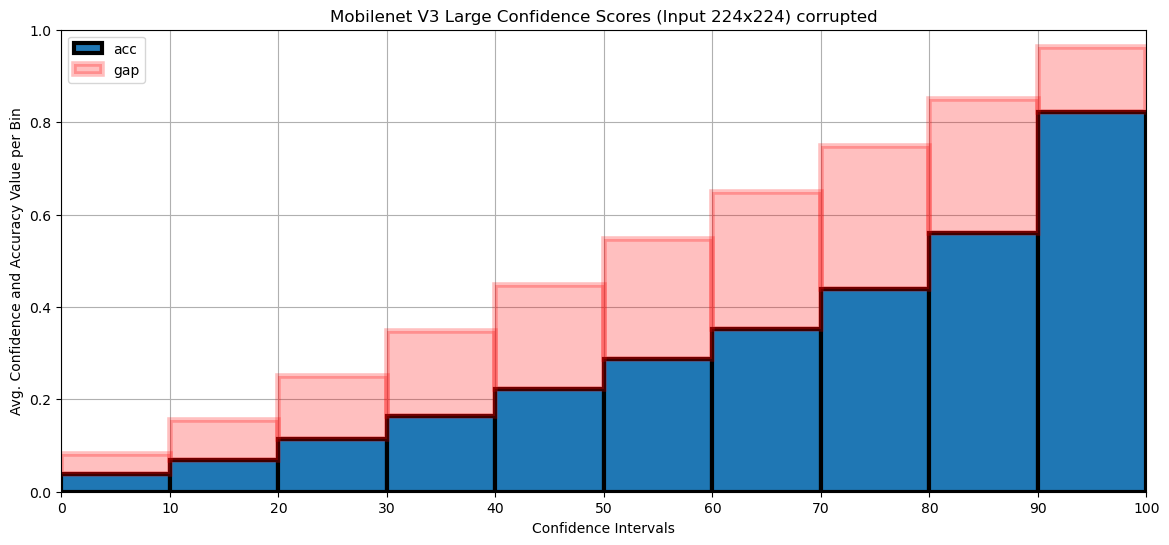

In [47]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.bar(xpos[:-1],corr_accs64_cal,label="acc",width=5,edgecolor='black',linewidth=3)
plt.xticks(xtickpos, bars)
bot = []
top = []
for i,c in enumerate(corr_confs64_cal):
    if c > corr_accs64_cal[i]:
        bot.append(corr_accs64_cal[i])
        top.append(c-corr_accs64_cal[i])
    else:
        bot.append(c)
        top.append(corr_accs64_cal[i]-c)
print(top)
print(bot)
plt.bar(xpos[:-1],top,label="gap",width=5,edgecolor='red',bottom=bot,color='red',alpha=0.25,linewidth=4)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 224x224) corrupted')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])
plt.grid()

In [48]:
print("ECE:",sum([abs(corr_accs64_cal[i] - corr_confs64_cal[i])*corr_confs_hist64[i] for i in range(len(corr_confs64_cal))]))

ECE: tensor(0.1913)


# Online Accuracies

## Deterministic Baselines

get all the confidences and results for each model on each dataset
* pre-computing then reusing results after is faster
* only works for fixed model
* this gives predictions in non-shuffled order, post-evaluation must be shuffled

In [5]:
# confidence is highest softmax output
# result is whether a prediction was correct

# all confs and results on clean sets
clean_confidences = torch.zeros(len(clean_val_loader.dataset))
clean_results = torch.zeros(len(clean_val_loader.dataset))
clean_confidences64 = torch.zeros(len(clean_val_loader.dataset))
clean_results64 = torch.zeros(len(clean_val_loader.dataset))

# all confs and results on corrupted sets
corr_confidences = torch.zeros(len(clean_val_loader.dataset)*len(corruptions))
corr_results = torch.zeros(len(clean_val_loader.dataset)*len(corruptions))
corr_confidences64 = torch.zeros(len(clean_val_loader.dataset)*len(corruptions))
corr_results64 = torch.zeros(len(clean_val_loader.dataset)*len(corruptions))

# put all datasets in fixed order
# fixed_order = CustomOrder(clean_val_loader.dataset)
# rand_corr_order = torch.randperm(15)

with torch.no_grad():
    # first get the clean results for 224 and 64
    batch_idx = 0
    for (img_batch, label_batch) in tqdm(clean_val_loader):
        img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')
        start = batch_idx*clean_val_loader.batch_size
        end = start + len(label_batch)

        # get the model's softmax output and class predictions
        conf, pred = torch.max(F.softmax(model(img_batch), dim=1), 1)
        res = pred.eq(label_batch)
        conf,res = conf.to('cpu'),res.to('cpu')

        clean_confidences[start:end] = conf
        clean_results[start:end] = res
        batch_idx += 1
    torch.save(clean_confidences,"accs/clean_confs224.pt")
    torch.save(clean_results,"accs/clean_results224.pt")
    batch_idx = 0
    for (img_batch, label_batch) in tqdm(clean_val_loader64):
        img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')
        start = batch_idx*clean_val_loader64.batch_size
        end = start + len(label_batch)

        # get the model's softmax output and class predictions
        conf, pred = torch.max(F.softmax(model64(img_batch), dim=1), 1)
        res = pred.eq(label_batch)
        conf,res = conf.to('cpu'),res.to('cpu')

        clean_confidences64[start:end] = conf
        clean_results64[start:end] = res
        batch_idx += 1
    torch.save(clean_confidences64,"accs/clean_confs64.pt")
    torch.save(clean_results64,"accs/clean_results64.pt")
    # get corrupted results
    for dl_idx, data_loader in enumerate(corr_val_loaders):
        print(corruptions[dl_idx])
        idx = 0
        for (img_batch, label_batch) in tqdm(data_loader):
            img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')

            start = dl_idx*len(data_loader.dataset) + idx*data_loader.batch_size
            end = start + len(label_batch)

            # get the model's softmax output and class predictions, then get a mask of correct predictions
            conf, pred = torch.max(F.softmax(model(img_batch), dim=1), 1)
            acc = pred.eq(label_batch)
            conf,pred,acc = conf.to('cpu'),pred.to('cpu'),acc.to('cpu')

            corr_confidences[start:end] = conf
            corr_results[start:end] = acc

            idx +=  1
    torch.save(corr_confidences,"accs/corr_confs224.pt")
    torch.save(corr_results,"accs/corr_results224.pt")
    for dl_idx, data_loader in enumerate(corr_val_loaders64):
        print(corruptions[dl_idx])
        idx = 0
        for (img_batch, label_batch) in tqdm(data_loader):
            img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')

            start = dl_idx*len(data_loader.dataset) + idx*data_loader.batch_size
            end = start + len(label_batch)

            # get the model's softmax output and class predictions, then get a mask of correct predictions
            conf, pred = torch.max(F.softmax(model64(img_batch), dim=1), 1)
            acc = pred.eq(label_batch)
            conf,pred,acc = conf.to('cpu'),pred.to('cpu'),acc.to('cpu')

            corr_confidences64[start:end] = conf
            corr_results64[start:end] = acc

            idx +=  1
    torch.save(corr_confidences64,"accs/corr_confs64.pt")
    torch.save(corr_results64,"accs/corr_results64.pt")

100%|██████████| 391/391 [00:18<00:00, 21.39it/s]


gaussian_noise


100%|██████████| 391/391 [00:30<00:00, 12.99it/s]


impulse_noise


100%|██████████| 391/391 [00:29<00:00, 13.12it/s]


shot_noise


100%|██████████| 391/391 [00:29<00:00, 13.32it/s]


defocus_blur


100%|██████████| 391/391 [00:26<00:00, 14.63it/s]


glass_blur


100%|██████████| 391/391 [00:27<00:00, 14.13it/s]


motion_blur


100%|██████████| 391/391 [00:27<00:00, 14.20it/s]


zoom_blur


100%|██████████| 391/391 [00:27<00:00, 14.25it/s]


snow


100%|██████████| 391/391 [00:28<00:00, 13.95it/s]


frost


100%|██████████| 391/391 [00:23<00:00, 16.41it/s]


fog


100%|██████████| 391/391 [00:22<00:00, 17.27it/s]


brightness


100%|██████████| 391/391 [00:23<00:00, 16.67it/s]


contrast


100%|██████████| 391/391 [00:22<00:00, 17.31it/s]


elastic_transform


100%|██████████| 391/391 [00:23<00:00, 16.80it/s]


jpeg_compression


100%|██████████| 391/391 [00:22<00:00, 17.70it/s]


pixelate


100%|██████████| 391/391 [00:23<00:00, 16.75it/s]


gaussian_noise


100%|██████████| 391/391 [00:04<00:00, 84.34it/s]


impulse_noise


100%|██████████| 391/391 [00:04<00:00, 85.19it/s]


shot_noise


100%|██████████| 391/391 [00:04<00:00, 84.32it/s]


defocus_blur


100%|██████████| 391/391 [00:04<00:00, 86.68it/s]


glass_blur


100%|██████████| 391/391 [00:04<00:00, 85.74it/s]


motion_blur


100%|██████████| 391/391 [00:04<00:00, 87.31it/s]


zoom_blur


100%|██████████| 391/391 [00:04<00:00, 87.22it/s]


snow


100%|██████████| 391/391 [00:04<00:00, 85.41it/s]


frost


100%|██████████| 391/391 [00:04<00:00, 78.90it/s]


fog


100%|██████████| 391/391 [00:05<00:00, 77.67it/s]


brightness


100%|██████████| 391/391 [00:05<00:00, 75.00it/s]


contrast


100%|██████████| 391/391 [00:05<00:00, 77.94it/s]


elastic_transform


100%|██████████| 391/391 [00:04<00:00, 78.74it/s]


jpeg_compression


100%|██████████| 391/391 [00:04<00:00, 78.44it/s]


pixelate


100%|██████████| 391/391 [00:04<00:00, 78.59it/s]


In [5]:
# all confs and results on clean sets
clean_confidences = torch.load("accs/clean_confs224.pt")
clean_results = torch.load("accs/clean_results224.pt")
clean_confidences64 = torch.load("accs/clean_confs64.pt")
clean_results64 = torch.load("accs/clean_results64.pt")

# all confs and results on corrupted sets
corr_confidences = torch.load("accs/corr_confs224.pt")
corr_results = torch.load("accs/corr_results224.pt")
corr_confidences64 = torch.load("accs/corr_confs64.pt")
corr_results64 = torch.load("accs/corr_results64.pt")

### setting the ordering

In [6]:
from torch.utils.data import Subset

from torch.utils.data.sampler import Sampler

class CustomOrder(Sampler):
    def __init__(self, dataset):
        self.order = torch.randperm(len(dataset),)
        
    def __iter__(self):
        return iter(self.order)
    
    def __len__(self):
        return len(self.order)

rand_order = CustomOrder(clean_val_loader.dataset)
rand_corr_order = torch.randperm(15)

### evaluating strategies for fixed model on clean set

In [7]:
# clean baseline
clean_online_acc = []
clean_online_efficiency = []
clean_online_acc64 = []
clean_online_efficiency64 = []
clean_online_ops = []
clean_online_ops64 = []
clean_naive_online_acc = []
clean_naive_efficiency = []
clean_naive_ops = []
clean_oracle_acc = []
clean_oracle_efficiency = []
clean_oracle_ops = []
idxs = []

num_imgs = 0

clean_num_correct = 0
clean_num_correct64 = 0
clean_num_naive_correct = 0
clean_num_oracle_correct = 0


clean_naive_num_wrong_decisions = 0
clean_naive_num_choose_small = 0
clean_naive_num_choose_big = 0
clean_oracle_num_choose_small = 0
clean_oracle_num_choose_big = 0

small_right_big_wrong = []
big_right_small_wrong = []

clean_overconfident_locations = []
clean_overconfident_imgs = []
clean_underconfident_locations = []
clean_underconfident_imgs = []

for sample_idx in tqdm(rand_order):
    num_imgs += 1
    # get the prediction
    out = clean_confidences[sample_idx]
    out64 = clean_confidences64[sample_idx]
    res = clean_results[sample_idx]
    res64 = clean_results64[sample_idx]
    clean_num_correct += res
    clean_num_correct64 += res64
    clean_online_acc.append(clean_num_correct/num_imgs)
    clean_online_acc64.append(clean_num_correct64/num_imgs)
    clean_online_efficiency.append(0)
    clean_online_efficiency64.append(1)
    clean_online_ops.append(234)
    clean_online_ops64.append(22)

    # oracle, if small is right choose small, else choose big
    if res64:
        clean_num_oracle_correct += res64
        clean_oracle_num_choose_small += 1
    else:
        clean_num_oracle_correct += res
        clean_oracle_num_choose_big += 1
    clean_oracle_acc.append(clean_num_oracle_correct/num_imgs) 
    clean_oracle_efficiency.append(clean_oracle_num_choose_small/num_imgs)   
    clean_oracle_ops.append((clean_oracle_num_choose_small*22+clean_oracle_num_choose_big*234)/num_imgs)

    if not res and res64:
        small_right_big_wrong.append(sample_idx)
    if not res64 and res:
        big_right_small_wrong.append(sample_idx)

    # naive strategy, if less than 50% confident, use big model
    if out64.item() < 0.50:
        clean_num_naive_correct += res
        clean_naive_num_choose_big += 1
        # if was underconfident
        if res64:
            clean_naive_num_wrong_decisions += 1
            clean_underconfident_imgs.append(sample_idx)
            clean_underconfident_locations.append(num_imgs)
    else:
        clean_num_naive_correct += res64
        clean_naive_num_choose_small += 1
        # if was overconfident
        if not res64 and res:
            clean_naive_num_wrong_decisions += 1
            clean_overconfident_imgs.append(sample_idx)
            clean_overconfident_locations.append(num_imgs)
    clean_naive_online_acc.append(clean_num_naive_correct/num_imgs)
    clean_naive_efficiency.append(clean_naive_num_choose_small/num_imgs)
    clean_naive_ops.append((clean_naive_num_choose_small*22+clean_naive_num_choose_big*(234+22))/num_imgs)

    idxs.append(num_imgs)

100%|██████████| 50000/50000 [00:01<00:00, 35036.40it/s]


### accuracy

In [266]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

(0.0, 1.1)

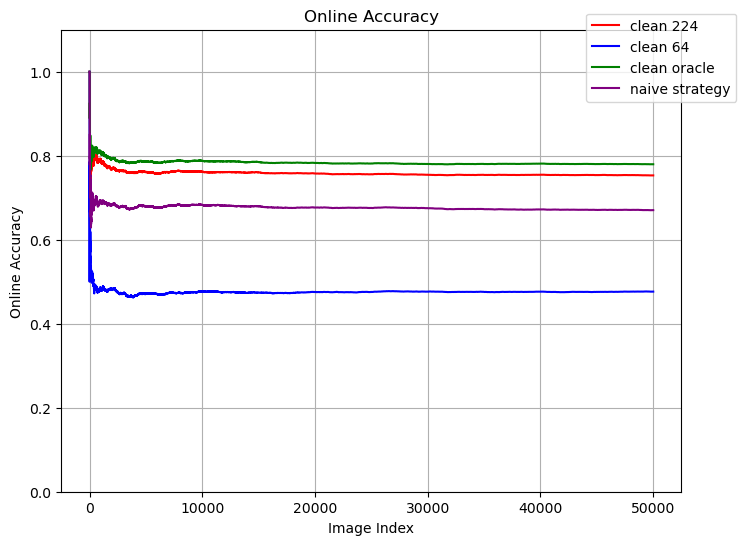

In [86]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,clean_online_acc,label='clean 224',color='red')
ax1.plot(idxs,clean_online_acc64,label='clean 64',color='blue')
ax1.plot(idxs,clean_oracle_acc,label='clean oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,clean_naive_online_acc,label='naive strategy',color='purple')

# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
ax1.set_ylabel("Online Accuracy")
# ax2.set_ylabel("# overconfident images")
ax1.set_xlabel("Image Index")
plt.grid()
plt.title("Online Accuracy")
plt.ylim([0,1.1])
# plt.xlim([0,200])

### efficiency

(-0.1, 1.1)

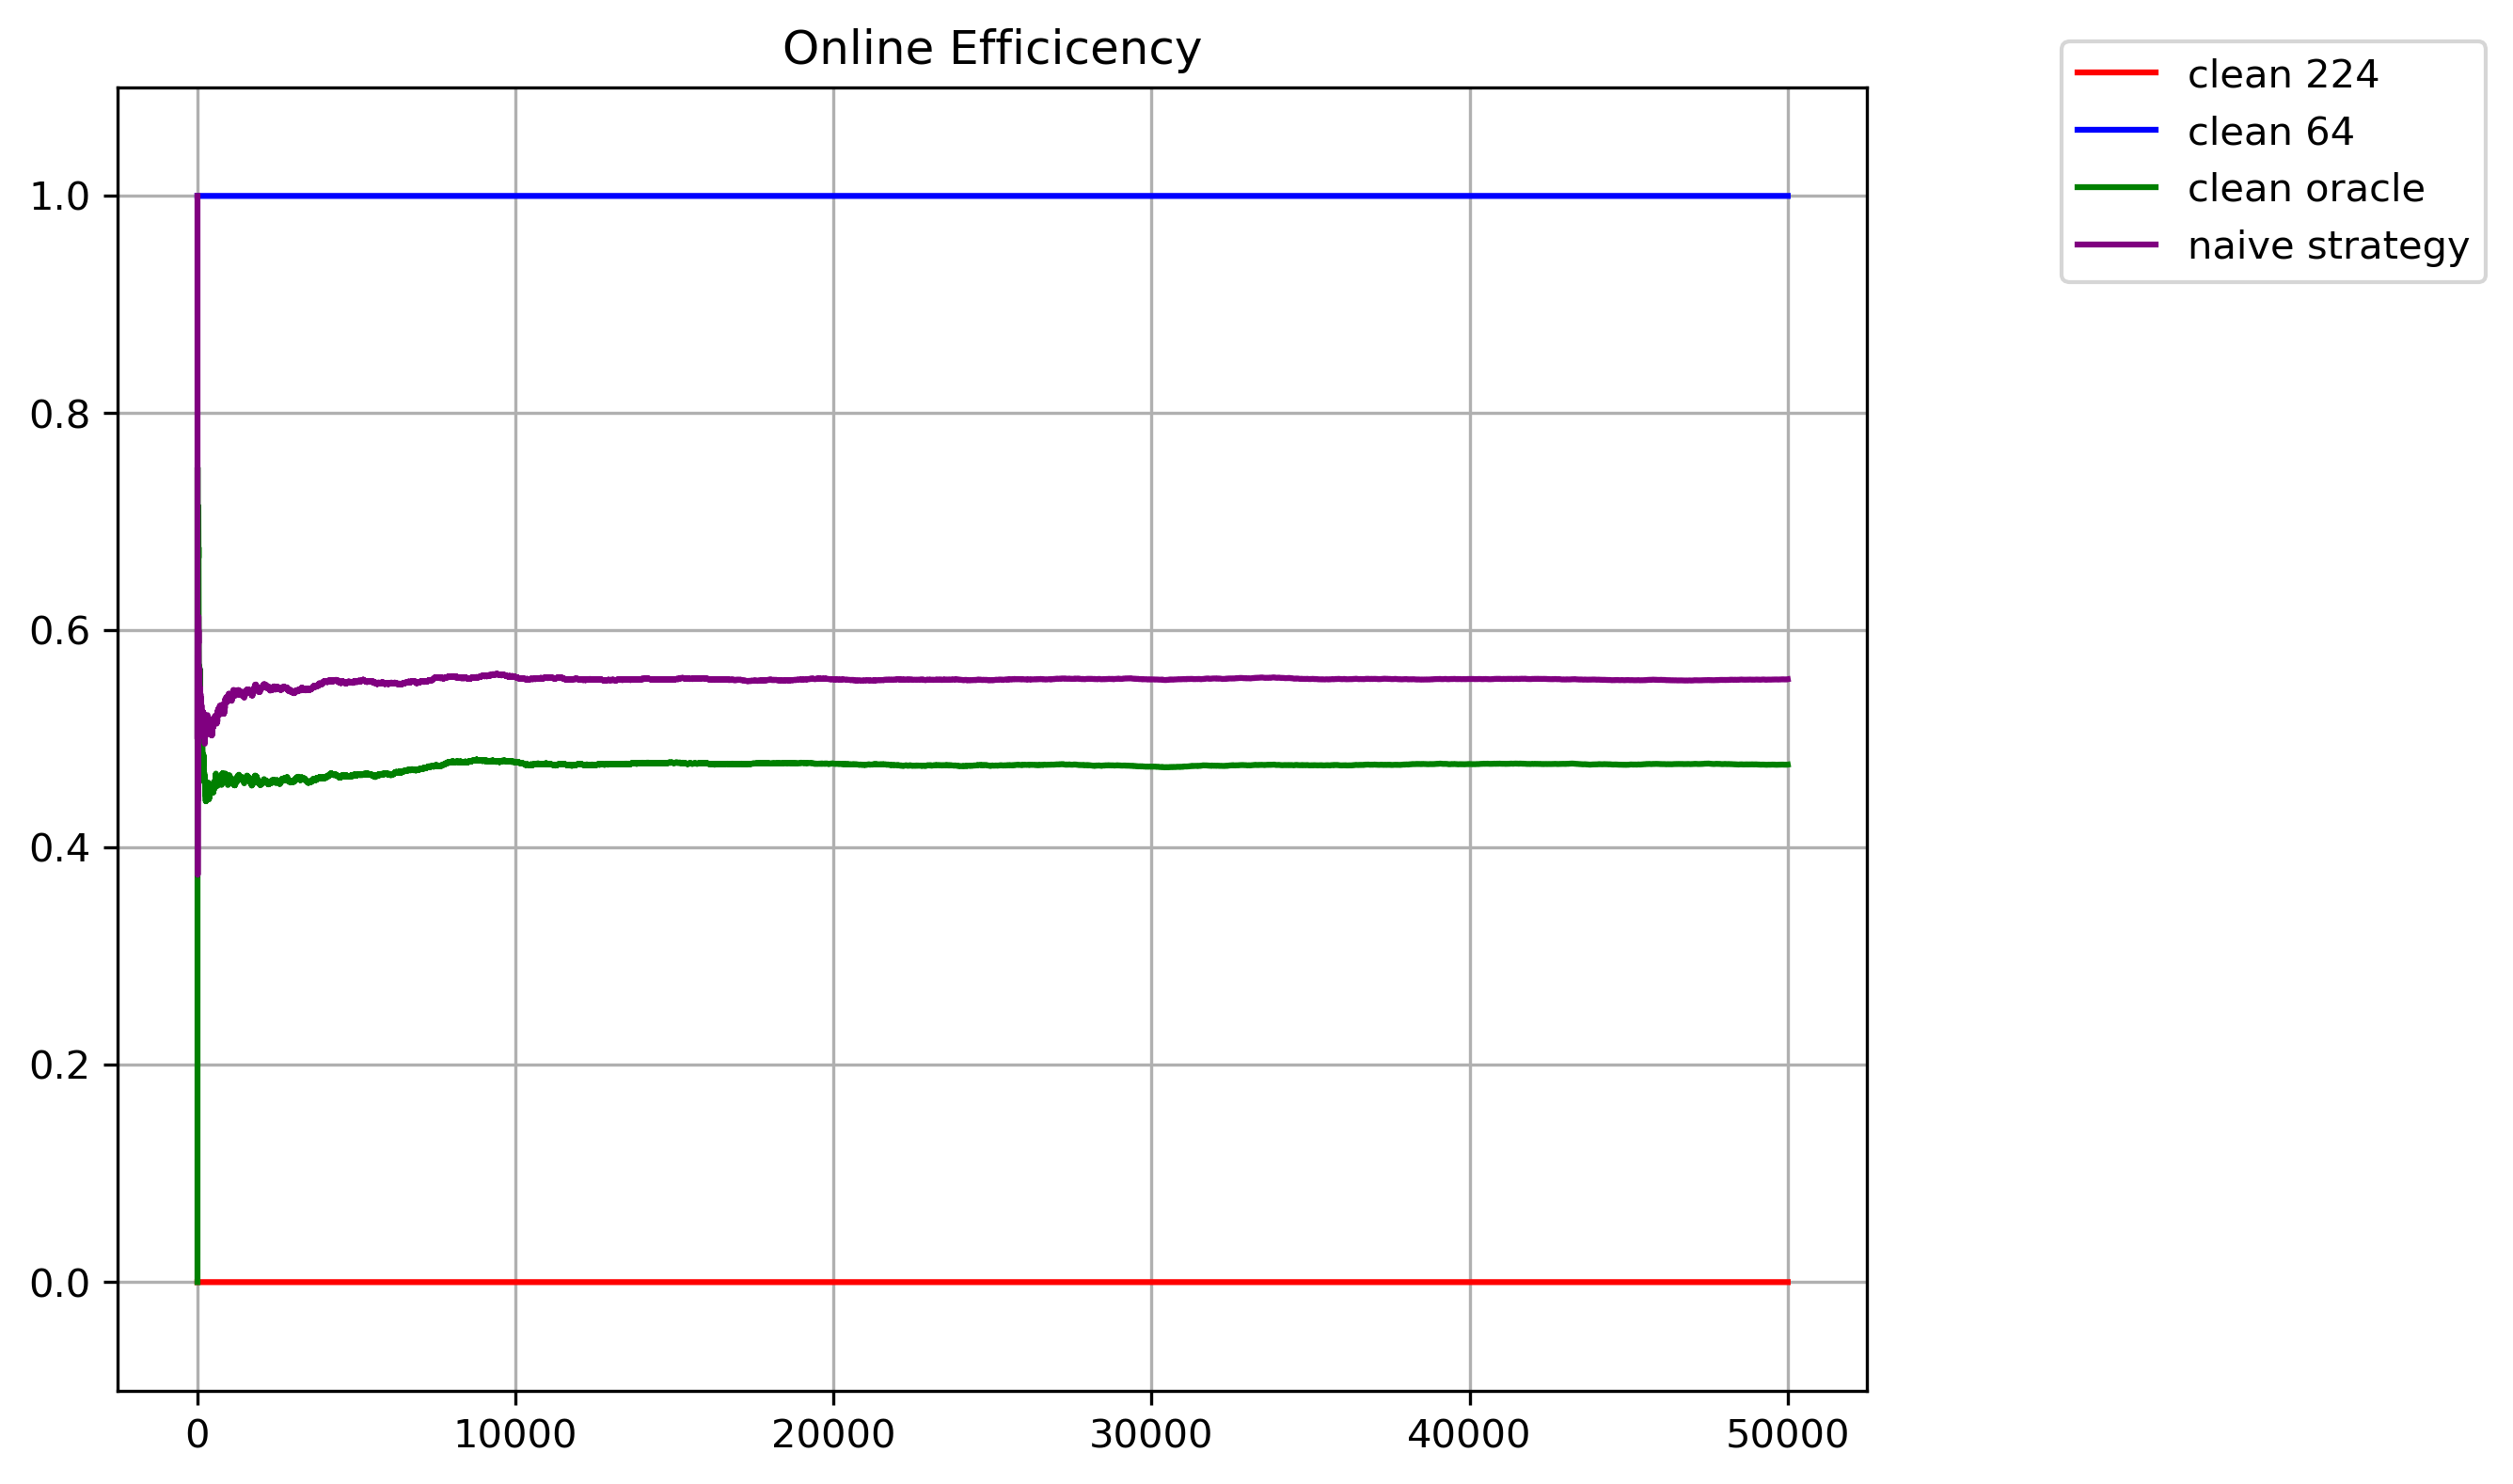

In [297]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,clean_online_efficiency,label='clean 224',color='red')
ax1.plot(idxs,clean_online_efficiency64,label='clean 64',color='blue')
ax1.plot(idxs,clean_oracle_efficiency,label='clean oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,clean_naive_efficiency,label='naive strategy',color='purple')
plt.title("Online Efficicency")
# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
# ax1.set_ylabel("Online Accuracy")
# ax2.set_ylabel("# overconfident images")
# ax1.set_xlabel("Image Index")
plt.grid()
plt.ylim([-0.1,1.1])
# plt.xlim([0,100])

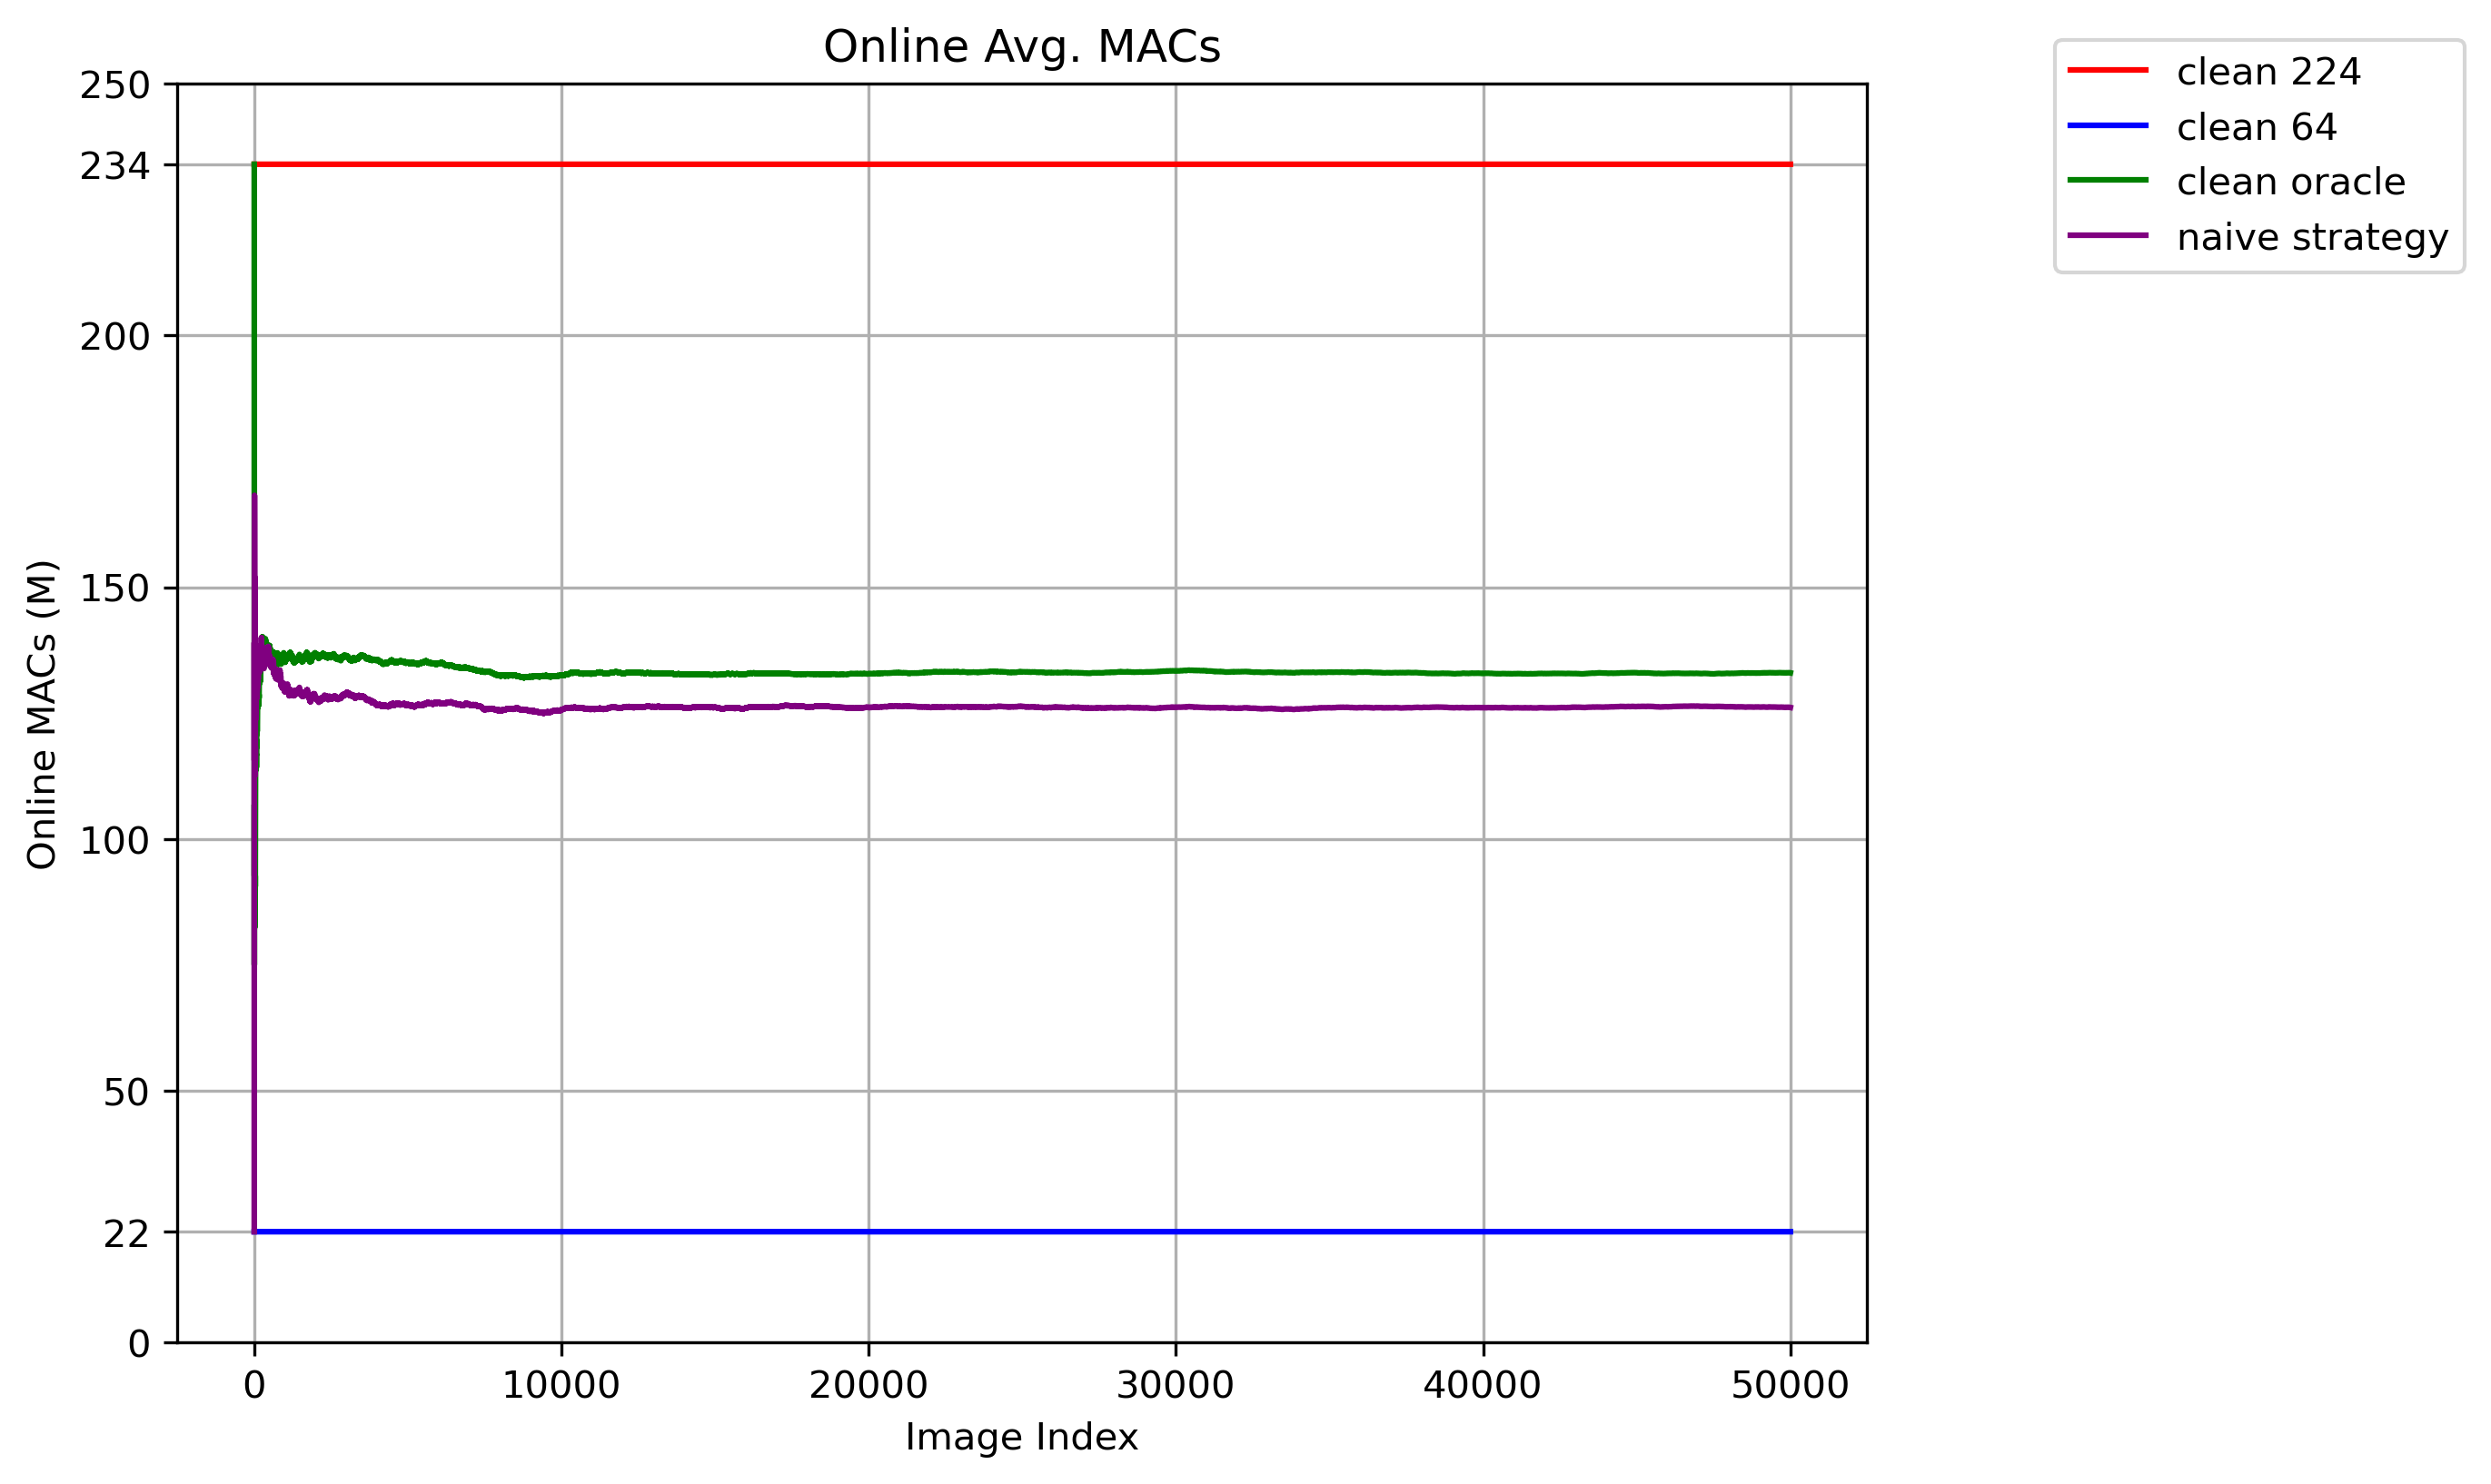

In [316]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,clean_online_ops,label='clean 224',color='red')
ax1.plot(idxs,clean_online_ops64,label='clean 64',color='blue')
ax1.plot(idxs,clean_oracle_ops,label='clean oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,clean_naive_ops,label='naive strategy',color='purple')
plt.title("Online Avg. MACs")
# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
ax1.set_ylabel("Online MACs (M)")
# ax2.set_ylabel("# overconfident images")
ax1.set_xlabel("Image Index")
ax1.set_yticks(list(plt.yticks()[0]) + [22,234])
plt.grid()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([672], device='cuda:0') 672  mountain tent


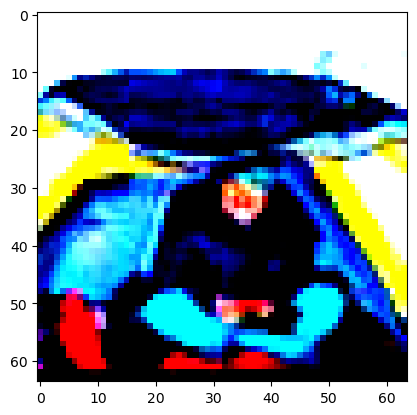

In [80]:
small_correct_big_wrong_idxs = torch.logical_and((clean_results64 == 1),(clean_results == 0)).nonzero()
img,t = clean_val_loader64.dataset[small_right_big_wrong[550]]
plt.imshow(img.permute(1,2,0))
print(model64(img.unsqueeze(0).to('cuda')).argmax(dim=1),t,clean_val_loader.dataset.class_name_map[clean_val_loader.dataset.class_id_list[t]])

### pareto curve for accuracy and efficiency

In [17]:
efficiencies = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
acc_for_eff = []
big_model_idxs = [torch.zeros(len(clean_results),dtype=torch.bool) for i in range(len(efficiencies))]
small_model_idxs = [torch.zeros(len(clean_results),dtype=torch.bool) for i in range(len(efficiencies))]
for i,eff in enumerate(efficiencies):
    
    curr_acc = 0
    # choose only big
    if eff == 0:
        big_model_idxs[i][:] = True
        continue
    # choose only small
    if eff == 1:
        small_model_idxs[i][:] = True
        continue
    
    
    # for a given efficiency
    eff_thresh = int(eff*len(clean_confidences))
    total_thresh = int(len(clean_confidences))

    # get all idxs where small correct, big wrong
    small_correct_big_wrong_idxs = torch.logical_and((clean_results64 == 1),(clean_results == 0)).nonzero()

    # get all idxs where small and big correct
    small_big_correct_idxs = torch.logical_and((clean_results64 == 1),(clean_results == 1)).nonzero()

    # get all idxs where small wrong, big correct
    small_wrong_big_correct_idxs = torch.logical_and((clean_results64 == 0),(clean_results == 1)).nonzero()

    # get all idxs where big wrong and small wrong
    small_wrong_big_wrong_idxs = torch.logical_and((clean_results64 == 0),(clean_results == 0)).nonzero()
    
    curr_idxs = torch.clone(small_correct_big_wrong_idxs)

    # if above eff threshold (up to eff thresh is small, rest is big)
    if len(curr_idxs) > eff_thresh:
        # remove small until reach efficiency
        curr_idxs = curr_idxs[:eff_thresh]
        small_model_idxs[i][curr_idxs] = True # up until eff thresh

        # add big correct that hven't been taken
        taken = torch.zeros(len(clean_results))
        taken[curr_idxs] = 1
        big_correct_no_conflict = torch.logical_and((clean_results == 1),(taken == 0)).nonzero()
        curr_idxs = torch.cat((curr_idxs,big_correct_no_conflict))
        
        # if above total thresh
        if len(curr_idxs) > total_thresh:
            # remove some big to fit the threshold
            curr_idxs = curr_idxs[:total_thresh]
            big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
            continue
        else:
            # add some big wrong and small wrong to fit the threshold
            amnt = total_thresh - len(curr_idxs)
            taken = torch.zeros(len(clean_results))
            taken[curr_idxs] = 1
            big_incorrect_no_conflict = torch.logical_and((clean_results == 0),(taken == 0)).nonzero()
            curr_idxs = torch.cat((curr_idxs,big_incorrect_no_conflict[:amnt]))
            big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
            continue
    else: 
        # get more by adding predictions which both small and big correct
        curr_idxs = torch.cat((curr_idxs,small_big_correct_idxs))

        # if above efficicency threshold
        if len(curr_idxs) > eff_thresh:
            # remove some small/big correct
            curr_idxs = curr_idxs[:eff_thresh]
            small_model_idxs[i][curr_idxs] = True # up until eff thresh

            # add big correct that hven't been taken
            taken = torch.zeros(len(clean_results))
            taken[curr_idxs] = 1
            big_correct_no_conflict = torch.logical_and((clean_results == 1),(taken == 0)).nonzero()
            curr_idxs = torch.cat((curr_idxs,big_correct_no_conflict))
            
            # if above total thresh
            if len(curr_idxs) > total_thresh:
                # remove some big to fit the threshold
                curr_idxs = curr_idxs[:total_thresh]
                big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                continue
            else:
                # add some big wrong that doesn't conflict
                amnt = total_thresh - len(curr_idxs)
                taken = torch.zeros(len(clean_results))
                taken[curr_idxs] = 1
                big_incorrect_no_conflict = torch.logical_and((clean_results == 0),(taken == 0)).nonzero()
                curr_idxs = torch.cat((curr_idxs,big_incorrect_no_conflict[:amnt]))
                big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                continue
        else:
            # add small wrong big wrong
            curr_idxs = torch.cat((curr_idxs,small_wrong_big_wrong_idxs))

            # if above eff thresh
            if len(curr_idxs) > eff_thresh:
                curr_idxs = curr_idxs[:eff_thresh]
                small_model_idxs[i][curr_idxs] = True # up until eff thresh

                # add big correct that hven't been taken
                taken = torch.zeros(len(clean_results))
                taken[curr_idxs] = 1
                big_correct_no_conflict = torch.logical_and((clean_results == 1),(taken == 0)).nonzero()
                curr_idxs = torch.cat((curr_idxs,big_correct_no_conflict))

                # if above total thresh
                if len(curr_idxs) > total_thresh:
                    # remove some big to fit the threshold
                    curr_idxs = curr_idxs[:total_thresh]
                    big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                    continue
                else:
                    # add some big wrong that haven't been taken
                    amnt = total_thresh - len(curr_idxs)
                    taken = torch.zeros(len(clean_results))
                    taken[curr_idxs] = 1
                    big_incorrect_no_conflict = torch.logical_and((clean_results == 0),(taken == 0)).nonzero()
                    curr_idxs = torch.cat((curr_idxs,big_incorrect_no_conflict[:amnt]))
                    big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                    continue
            else:
                # add small wrong and big correct to reach eff thresh
                amnt = eff_thresh - len(curr_idxs)
                curr_idxs = torch.cat((curr_idxs,small_wrong_big_correct_idxs[:amnt]))
                small_model_idxs[i][curr_idxs] = True # up until eff thresh

                # add big correct that hven't been taken
                taken = torch.zeros(len(clean_results))
                taken[curr_idxs] = 1
                big_correct_no_conflict = torch.logical_and((clean_results == 1),(taken == 0)).nonzero()
                curr_idxs = torch.cat((curr_idxs,big_correct_no_conflict))

                # if above total thresh
                if len(curr_idxs) > total_thresh:
                    # remove some big to fit the threshold
                    curr_idxs = curr_idxs[:total_thresh]
                    big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                    continue
                else:
                    # add some big wrong that haven't been taken
                    amnt = total_thresh - len(curr_idxs)
                    taken = torch.zeros(len(clean_results))
                    taken[curr_idxs] = 1
                    big_incorrect_no_conflict = torch.logical_and((clean_results == 0),(taken == 0)).nonzero()
                    curr_idxs = torch.cat((curr_idxs,big_incorrect_no_conflict[:amnt]))
                    big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                    continue


In [18]:
acc_for_eff = []
for i, eff in enumerate(efficiencies):
    assert sum(small_model_idxs[i]).item() + sum(big_model_idxs[i]).item() == len(clean_results) # total num predictions correct
    assert sum(torch.logical_and(small_model_idxs[5],big_model_idxs[5])).item() == 0 # no overlapping idxs
    acc_for_eff.append(((sum(clean_results64[small_model_idxs[i]])+sum(clean_results[big_model_idxs[i]]))/len(clean_results)).item())

acc_eff_plot

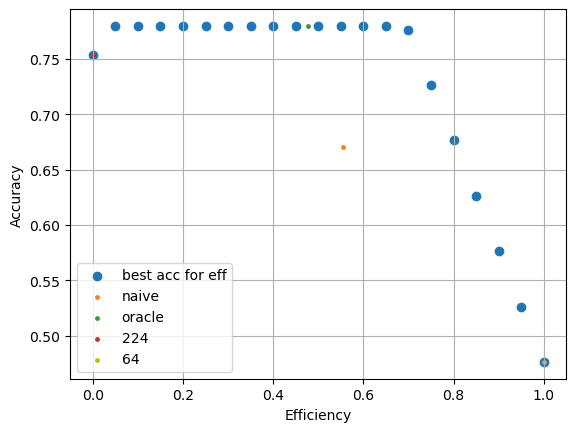

In [19]:
plt.scatter(efficiencies,acc_for_eff,label="best acc for eff")
plt.scatter(clean_naive_efficiency[-1],clean_naive_online_acc[-1],label="naive",s=6)
plt.scatter(clean_oracle_efficiency[-1],clean_oracle_acc[-1],label="oracle",s=6)
plt.scatter(clean_online_efficiency[-1],clean_online_acc[-1],label="224",s=6)
plt.scatter(clean_online_efficiency64[-1],clean_online_acc64[-1],label="64",s=6,c='y')
plt.grid()
plt.xlabel("Efficiency")
plt.ylabel("Accuracy")
plt.legend()

In [7]:
efficiencies = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
accs = []
for e in efficiencies:
    x_sr = clean_results64.numpy()
    x_br = clean_results.numpy()

    x_cs = cp.Variable(50000, boolean = True)
    x_cb = cp.Variable(50000, boolean = True)
    ones_vec = np.ones(50000)

    constraints = []
    constraints = [x_cs + x_cb == ones_vec, x_cs.T@ones_vec == int(e*50000)]
    acc = x_sr.T@x_cs + x_br.T@x_cb

    problem = cp.Problem(cp.Maximize(acc), constraints)

    problem.solve()
    accs.append(problem.value)
    # print("status:", problem.status)
    # print("optimal value", problem.value)
    # print("optimal var", x_cs.value, x_cb.value)

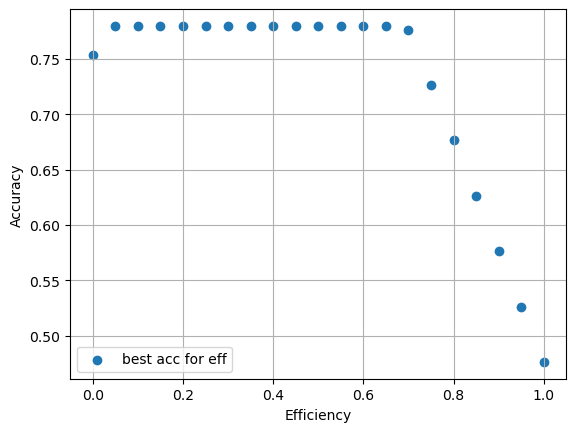

In [8]:
accs = [acc/50000 for acc in accs]
plt.scatter(efficiencies,accs,label="best acc for eff")
# plt.scatter(clean_naive_efficiency[-1],clean_naive_online_acc[-1],label="naive",s=6)
# plt.scatter(clean_oracle_efficiency[-1],clean_oracle_acc[-1],label="oracle",s=6)
# plt.scatter(clean_online_efficiency[-1],clean_online_acc[-1],label="224",s=6)
# plt.scatter(clean_online_efficiency64[-1],clean_online_acc64[-1],label="64",s=6,c='y')
plt.grid()
plt.xlabel("Efficiency")
plt.ylabel("Accuracy")
plt.legend()

In [91]:
min_ops = 22*50000
max_ops = (22+234)*50000
ops = np.linspace(min_ops,max_ops,20)
accs = []
effs = []
for o in ops:
    x_sr = clean_results64.numpy()
    x_br = clean_results.numpy()

    x_cs = cp.Variable(50000, boolean = True)
    x_cb = cp.Variable(50000, boolean = True)
    ones_vec = np.ones(50000)

    constraints = []
    constraints = [x_cs + x_cb == ones_vec, 22*x_cs.T@ones_vec + (22+234)*x_cb.T@ones_vec <= int(o)]
    acc = x_sr.T@x_cs + x_br.T@x_cb

    problem = cp.Problem(cp.Maximize(acc), constraints)

    problem.solve()
    accs.append(problem.value)
    effs.append(sum(x_cs.value)/50000)
    # print("status:", problem.status)
    # print("optimal value", problem.value)
    # print("optimal var", sum(x_cs.value), sum(x_cb.value))

corr_rand_subset = torch.zeros(50000)
corr_rand_subset64 = torch.zeros(50000)
rand_order = torch.randperm(50000)
corr_rand_subset[0:5] = clean_results[rand_order[0:5]]
corr_rand_subset64[0:5] = clean_results64[rand_order[0:5]]
for c_i in range(15):
    start = 5+c_i*3333
    end = start + 3333
    corr_rand_subset[start:end] = corr_results[c_i*50000+rand_order[start:end]]
    corr_rand_subset64[start:end] = corr_results64[c_i*50000+rand_order[start:end]]


corr_accs = []
corr_effs = []
for o in ops:
    x_sr = corr_rand_subset64.numpy()
    x_br = corr_rand_subset.numpy()

    x_cs = cp.Variable(50000, boolean = True)
    x_cb = cp.Variable(50000, boolean = True)
    ones_vec = np.ones(50000)

    constraints = []
    constraints = [x_cs + x_cb == ones_vec, 22*x_cs.T@ones_vec + (22+234)*x_cb.T@ones_vec <= int(o)]
    acc = x_sr.T@x_cs + x_br.T@x_cb

    problem = cp.Problem(cp.Maximize(acc), constraints)

    problem.solve()
    corr_accs.append(problem.value)
    corr_effs.append(sum(x_cs.value)/50000)
    # print("status:", problem.status)
    # print("optimal value", problem.value)
    # print("optimal var", x_cs.value, x_cb.value)

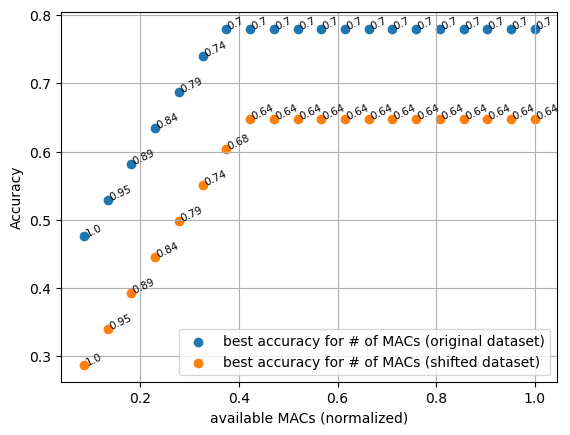

In [92]:
accs2 = [acc/50000 for acc in accs]
corr_accs2 = [acc/50000 for acc in corr_accs]
fig,ax1 = plt.subplots()
ax1.scatter(ops/max_ops,accs2,label="best accuracy for # of MACs (original dataset)")
ax1.scatter(ops/max_ops,corr_accs2,label="best accuracy for # of MACs (shifted dataset)")
# plt.scatter(clean_naive_efficiency[-1],clean_naive_online_acc[-1],label="naive",s=6)
# plt.scatter(clean_oracle_efficiency[-1],clean_oracle_acc[-1],label="oracle",s=6)
# plt.scatter(clean_online_efficiency[-1],clean_online_acc[-1],label="224",s=6)
# plt.scatter(clean_online_efficiency64[-1],clean_online_acc64[-1],label="64",s=6,c='y')
ax1.grid()
ax1.set_xlabel("available MACs (normalized)")
ax1.set_ylabel("Accuracy")
ax1.legend()
effs2 = [round(eff,2) for eff in effs]
corr_effs2 = [round(corr_eff,2) for corr_eff in corr_effs]
for i, txt in enumerate(effs2):
    ax1.annotate(txt, ((ops/max_ops)[i], accs2[i]),rotation=25, size=7.5)
    ax1.annotate(corr_effs2[i], ((ops/max_ops)[i], corr_accs2[i]),rotation=25, size=7.5)

### evaluating strategies for fixed model on corrupt set

In [44]:
# corr baseline
corr_online_acc = []
corr_online_efficiency = []
corr_online_acc64 = []
corr_online_efficiency64 = []
corr_online_ops = []
corr_online_ops64 = []
corr_naive_online_acc = []
corr_naive_efficiency = []
corr_naive_ops = []
corr_oracle_acc = []
corr_oracle_efficiency = []
corr_oracle_ops = []
idxs = []

num_imgs = 0

corr_num_correct = 0
corr_num_correct64 = 0
corr_num_naive_correct = 0
corr_num_oracle_correct = 0


corr_naive_num_wrong_decisions = 0
corr_naive_num_choose_small = 0
corr_naive_num_choose_big = 0
corr_oracle_num_choose_small = 0
corr_oracle_num_choose_big = 0

small_right_big_wrong = []
big_right_small_wrong = []

corr_overconfident_locations = []
corr_overconfident_imgs = []
corr_underconfident_locations = []
corr_underconfident_imgs = []
transition_points = [1999]
corr_idx = 0
corr_img_count = 0

corr_sub_confs = torch.zeros(50000)
corr_sub_results = torch.zeros(50000)
corr_sub_confs64 = torch.zeros(50000)
corr_sub_results64 = torch.zeros(50000)

for sample_idx in tqdm(rand_order):
    # corruptions start after the first 2000 images
    if num_imgs-1 > 1999:
        # each corruption lasts 3200 images
        if corr_img_count == 3200:
            corr_idx += 1
            corr_img_count = 0
            transition_points.append(num_imgs)
        # get the prediction
        out = corr_confidences[rand_corr_order[corr_idx]*50000+sample_idx]
        out64 = corr_confidences64[rand_corr_order[corr_idx]*50000+sample_idx]
        res = corr_results[rand_corr_order[corr_idx]*50000+sample_idx]
        res64 = corr_results64[rand_corr_order[corr_idx]*50000+sample_idx]

        corr_sub_confs[num_imgs-1] = out
        corr_sub_confs64[num_imgs-1] = out64
        corr_sub_results[num_imgs-1] = res
        corr_sub_results64[num_imgs-1] = res64
        corr_img_count += 1
    else:
        # get the prediction
        out = clean_confidences[sample_idx]
        out64 = clean_confidences64[sample_idx]
        res = clean_results[sample_idx]
        res64 = clean_results64[sample_idx]
        
        corr_sub_confs[num_imgs-1] = out
        corr_sub_confs64[num_imgs-1] = out64
        corr_sub_results[num_imgs-1] = res
        corr_sub_results64[num_imgs-1] = res64

    num_imgs += 1
    
    corr_num_correct += res
    corr_num_correct64 += res64
    corr_online_acc.append(corr_num_correct/num_imgs)
    corr_online_acc64.append(corr_num_correct64/num_imgs)
    corr_online_efficiency.append(0)
    corr_online_efficiency64.append(1)
    corr_online_ops.append(234)
    corr_online_ops64.append(22)

    # oracle, if small is right choose small, else choose big
    if res64:
        corr_num_oracle_correct += res64
        corr_oracle_num_choose_small += 1
    else:
        corr_num_oracle_correct += res
        corr_oracle_num_choose_big += 1
    corr_oracle_acc.append(corr_num_oracle_correct/num_imgs) 
    corr_oracle_efficiency.append(corr_oracle_num_choose_small/num_imgs)   
    corr_oracle_ops.append((corr_oracle_num_choose_small*22+corr_oracle_num_choose_big*234)/num_imgs)

    if not res and res64:
        small_right_big_wrong.append(sample_idx)
    if not res64 and res:
        big_right_small_wrong.append(sample_idx)

    # naive strategy, if less than 50% confident, use big model
    if out64.item() < 0.50:
        corr_num_naive_correct += res
        corr_naive_num_choose_big += 1
        # if was underconfident
        if res64:
            corr_naive_num_wrong_decisions += 1
            corr_underconfident_imgs.append(sample_idx)
            corr_underconfident_locations.append(num_imgs)
    else:
        corr_num_naive_correct += res64
        corr_naive_num_choose_small += 1
        # if was overconfident
        if not res64 and res:
            corr_naive_num_wrong_decisions += 1
            corr_overconfident_imgs.append(sample_idx)
            corr_overconfident_locations.append(num_imgs)
    corr_naive_online_acc.append(corr_num_naive_correct/num_imgs)
    corr_naive_efficiency.append(corr_naive_num_choose_small/num_imgs)
    corr_naive_ops.append((corr_naive_num_choose_small*22+corr_naive_num_choose_big*(234+22))/num_imgs)

    idxs.append(num_imgs)

100%|██████████| 50000/50000 [00:02<00:00, 19313.00it/s]


### accuracy

(0.0, 1.0)

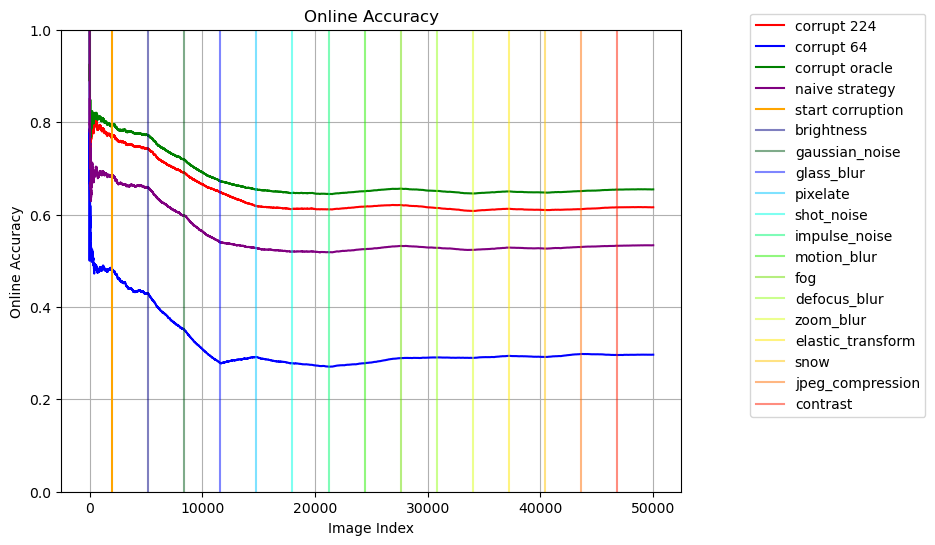

In [88]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,corr_online_acc,label='corrupt 224',color='red')
ax1.plot(idxs,corr_online_acc64,label='corrupt 64',color='blue')
ax1.plot(idxs,corr_oracle_acc,label='corrupt oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,corr_naive_online_acc,label='naive strategy',color='purple')
ax1.axvline(x = transition_points[0], color = 'orange', label = 'start corruption')
for i,x in enumerate(transition_points[1:]):
    plt.axvline(x =x, label = corruptions[rand_corr_order[i]],alpha=0.5)
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines[5:]):
    j.set_color(colors[i])

# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
ax1.set_ylabel("Online Accuracy")
# ax2.set_ylabel("# overconfident images")
ax1.set_xlabel("Image Index")
plt.grid()
plt.title("Online Accuracy")
plt.ylim([0,1])

### efficiency

(-0.1, 1.1)

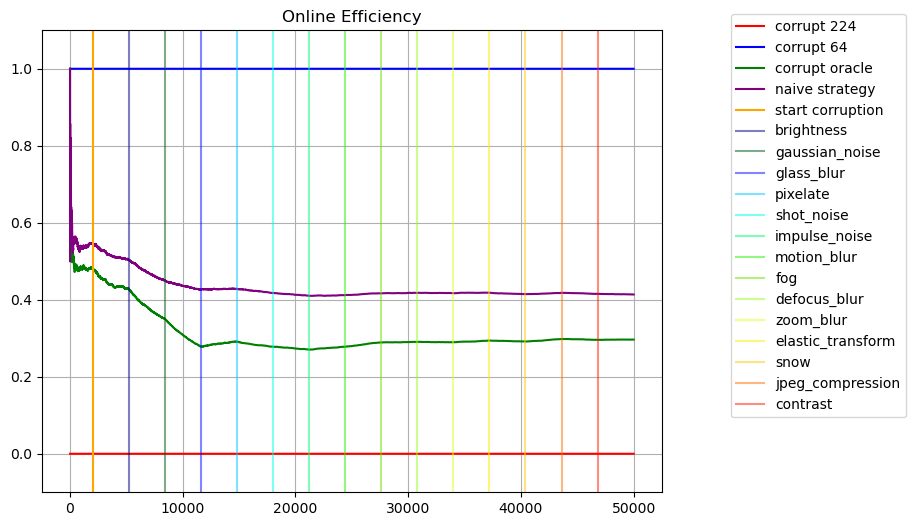

In [89]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,corr_online_efficiency,label='corrupt 224',color='red')
ax1.plot(idxs,corr_online_efficiency64,label='corrupt 64',color='blue')
ax1.plot(idxs,corr_oracle_efficiency,label='corrupt oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,corr_naive_efficiency,label='naive strategy',color='purple')
ax1.axvline(x = transition_points[0], color = 'orange', label = 'start corruption')
for i,x in enumerate(transition_points[1:]):
    plt.axvline(x =x, label = corruptions[rand_corr_order[i]],alpha=0.5)
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines[5:]):
    j.set_color(colors[i])

# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
# ax1.set_ylabel("Online Accuracy")
# ax2.set_ylabel("# overconfident images")
# ax1.set_xlabel("Image Index")
plt.grid()
plt.title("Online Efficiency")
plt.ylim([-0.1,1.1])

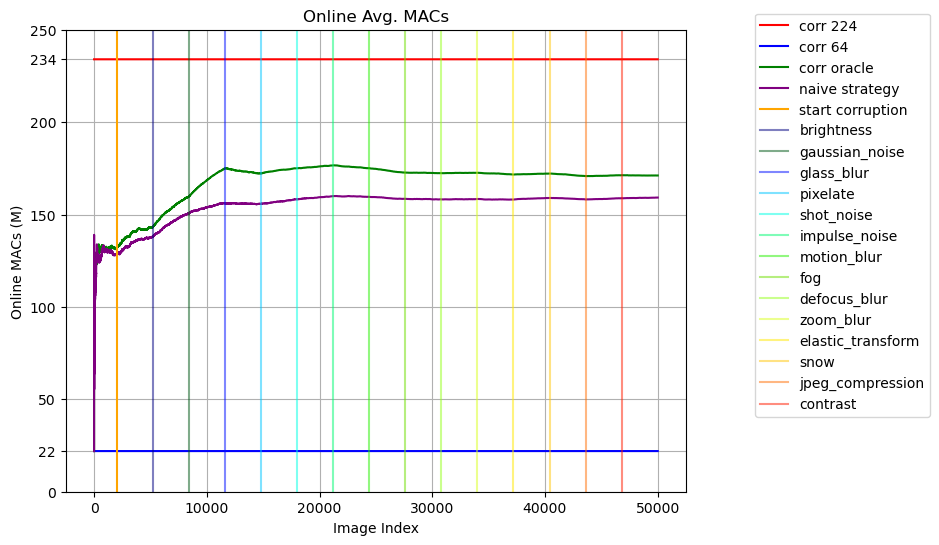

In [90]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,corr_online_ops,label='corr 224',color='red')
ax1.plot(idxs,corr_online_ops64,label='corr 64',color='blue')
ax1.plot(idxs,corr_oracle_ops,label='corr oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,corr_naive_ops,label='naive strategy',color='purple')
plt.title("Online Avg. MACs")
ax1.axvline(x = transition_points[0], color = 'orange', label = 'start corruption')
for i,x in enumerate(transition_points[1:]):
    plt.axvline(x =x, label = corruptions[rand_corr_order[i]],alpha=0.5)
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines[5:]):
    j.set_color(colors[i])
# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
ax1.set_yticks(list(plt.yticks()[0]) + [22,234])
ax1.set_ylabel("Online MACs (M)")
# ax2.set_ylabel("# overconfident images")
ax1.set_xlabel("Image Index")
plt.grid()

### pareto plot

In [1]:
efficiencies = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
acc_for_eff = []
big_model_idxs = [torch.zeros(len(corr_sub_results),dtype=torch.bool) for i in range(len(efficiencies))]
small_model_idxs = [torch.zeros(len(corr_sub_results),dtype=torch.bool) for i in range(len(efficiencies))]
for i,eff in enumerate(efficiencies):
    
    curr_acc = 0
    # choose only big
    if eff == 0:
        big_model_idxs[i][:] = True
        continue
    # choose only small
    if eff == 1:
        small_model_idxs[i][:] = True
        continue
    
    
    # for a given efficiency
    eff_thresh = int(eff*len(corr_sub_results))
    total_thresh = int(len(corr_sub_results))

    # get all idxs where small correct, big wrong
    small_correct_big_wrong_idxs = torch.logical_and((corr_sub_results64 == 1),(corr_sub_results == 0)).nonzero()

    # get all idxs where small and big correct
    small_big_correct_idxs = torch.logical_and((corr_sub_results64 == 1),(corr_sub_results == 1)).nonzero()

    # get all idxs where small wrong, big correct
    small_wrong_big_correct_idxs = torch.logical_and((corr_sub_results64 == 0),(corr_sub_results == 1)).nonzero()

    # get all idxs where big wrong and small wrong
    small_wrong_big_wrong_idxs = torch.logical_and((corr_sub_results64 == 0),(corr_sub_results == 0)).nonzero()
    
    curr_idxs = torch.clone(small_correct_big_wrong_idxs)

    # if above eff threshold (up to eff thresh is small, rest is big)
    if len(curr_idxs) > eff_thresh:
        # remove small until reach efficiency
        curr_idxs = curr_idxs[:eff_thresh]
        small_model_idxs[i][curr_idxs] = True # up until eff thresh

        # add big correct that hven't been taken
        taken = torch.zeros(len(corr_sub_results))
        taken[curr_idxs] = 1
        big_correct_no_conflict = torch.logical_and((corr_sub_results == 1),(taken == 0)).nonzero()
        curr_idxs = torch.cat((curr_idxs,big_correct_no_conflict))
        
        # if above total thresh
        if len(curr_idxs) > total_thresh:
            # remove some big to fit the threshold
            curr_idxs = curr_idxs[:total_thresh]
            big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
            continue
        else:
            # add some big wrong and small wrong to fit the threshold
            amnt = total_thresh - len(curr_idxs)
            taken = torch.zeros(len(corr_sub_results))
            taken[curr_idxs] = 1
            big_incorrect_no_conflict = torch.logical_and((corr_sub_results == 0),(taken == 0)).nonzero()
            curr_idxs = torch.cat((curr_idxs,big_incorrect_no_conflict[:amnt]))
            big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
            continue
    else: 
        # get more by adding predictions which both small and big correct
        curr_idxs = torch.cat((curr_idxs,small_big_correct_idxs))

        # if above efficicency threshold
        if len(curr_idxs) > eff_thresh:
            # remove some small/big correct
            curr_idxs = curr_idxs[:eff_thresh]
            small_model_idxs[i][curr_idxs] = True # up until eff thresh

            # add big correct that hven't been taken
            taken = torch.zeros(len(corr_sub_results))
            taken[curr_idxs] = 1
            big_correct_no_conflict = torch.logical_and((corr_sub_results == 1),(taken == 0)).nonzero()
            curr_idxs = torch.cat((curr_idxs,big_correct_no_conflict))
            
            # if above total thresh
            if len(curr_idxs) > total_thresh:
                # remove some big to fit the threshold
                curr_idxs = curr_idxs[:total_thresh]
                big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                continue
            else:
                # add some big wrong that doesn't conflict
                amnt = total_thresh - len(curr_idxs)
                taken = torch.zeros(len(corr_sub_results))
                taken[curr_idxs] = 1
                big_incorrect_no_conflict = torch.logical_and((corr_sub_results == 0),(taken == 0)).nonzero()
                curr_idxs = torch.cat((curr_idxs,big_incorrect_no_conflict[:amnt]))
                big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                continue
        else:
            # add small wrong big wrong
            curr_idxs = torch.cat((curr_idxs,small_wrong_big_wrong_idxs))

            # if above eff thresh
            if len(curr_idxs) > eff_thresh:
                curr_idxs = curr_idxs[:eff_thresh]
                small_model_idxs[i][curr_idxs] = True # up until eff thresh

                # add big correct that hven't been taken
                taken = torch.zeros(len(corr_sub_results))
                taken[curr_idxs] = 1
                big_correct_no_conflict = torch.logical_and((corr_sub_results == 1),(taken == 0)).nonzero()
                curr_idxs = torch.cat((curr_idxs,big_correct_no_conflict))

                # if above total thresh
                if len(curr_idxs) > total_thresh:
                    # remove some big to fit the threshold
                    curr_idxs = curr_idxs[:total_thresh]
                    big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                    continue
                else:
                    # add some big wrong that haven't been taken
                    amnt = total_thresh - len(curr_idxs)
                    taken = torch.zeros(len(corr_sub_results))
                    taken[curr_idxs] = 1
                    big_incorrect_no_conflict = torch.logical_and((corr_sub_results == 0),(taken == 0)).nonzero()
                    curr_idxs = torch.cat((curr_idxs,big_incorrect_no_conflict[:amnt]))
                    big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                    continue
            else:
                # add small wrong and big correct to reach eff thresh
                amnt = eff_thresh - len(curr_idxs)
                curr_idxs = torch.cat((curr_idxs,small_wrong_big_correct_idxs[:amnt]))
                small_model_idxs[i][curr_idxs] = True # up until eff thresh

                # add big correct that hven't been taken
                taken = torch.zeros(len(corr_sub_results))
                taken[curr_idxs] = 1
                big_correct_no_conflict = torch.logical_and((corr_sub_results == 1),(taken == 0)).nonzero()
                curr_idxs = torch.cat((curr_idxs,big_correct_no_conflict))

                # if above total thresh
                if len(curr_idxs) > total_thresh:
                    # remove some big to fit the threshold
                    curr_idxs = curr_idxs[:total_thresh]
                    big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                    continue
                else:
                    # add some big wrong that haven't been taken
                    amnt = total_thresh - len(curr_idxs)
                    taken = torch.zeros(len(corr_sub_results))
                    taken[curr_idxs] = 1
                    big_incorrect_no_conflict = torch.logical_and((corr_sub_results == 0),(taken == 0)).nonzero()
                    curr_idxs = torch.cat((curr_idxs,big_incorrect_no_conflict[:amnt]))
                    big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                    continue

NameError: name 'torch' is not defined

In [329]:
acc_for_eff = []
for i, eff in enumerate(efficiencies):
    assert sum(small_model_idxs[i]).item() + sum(big_model_idxs[i]).item() == len(corr_sub_results) # total num predictions correct
    assert sum(torch.logical_and(small_model_idxs[5],big_model_idxs[5])).item() == 0 # no overlapping idxs
    acc_for_eff.append(((sum(corr_sub_results64[small_model_idxs[i]])+sum(corr_sub_results[big_model_idxs[i]]))/len(corr_sub_results)).item())

acc_eff_plot

(0.0, 1.0)

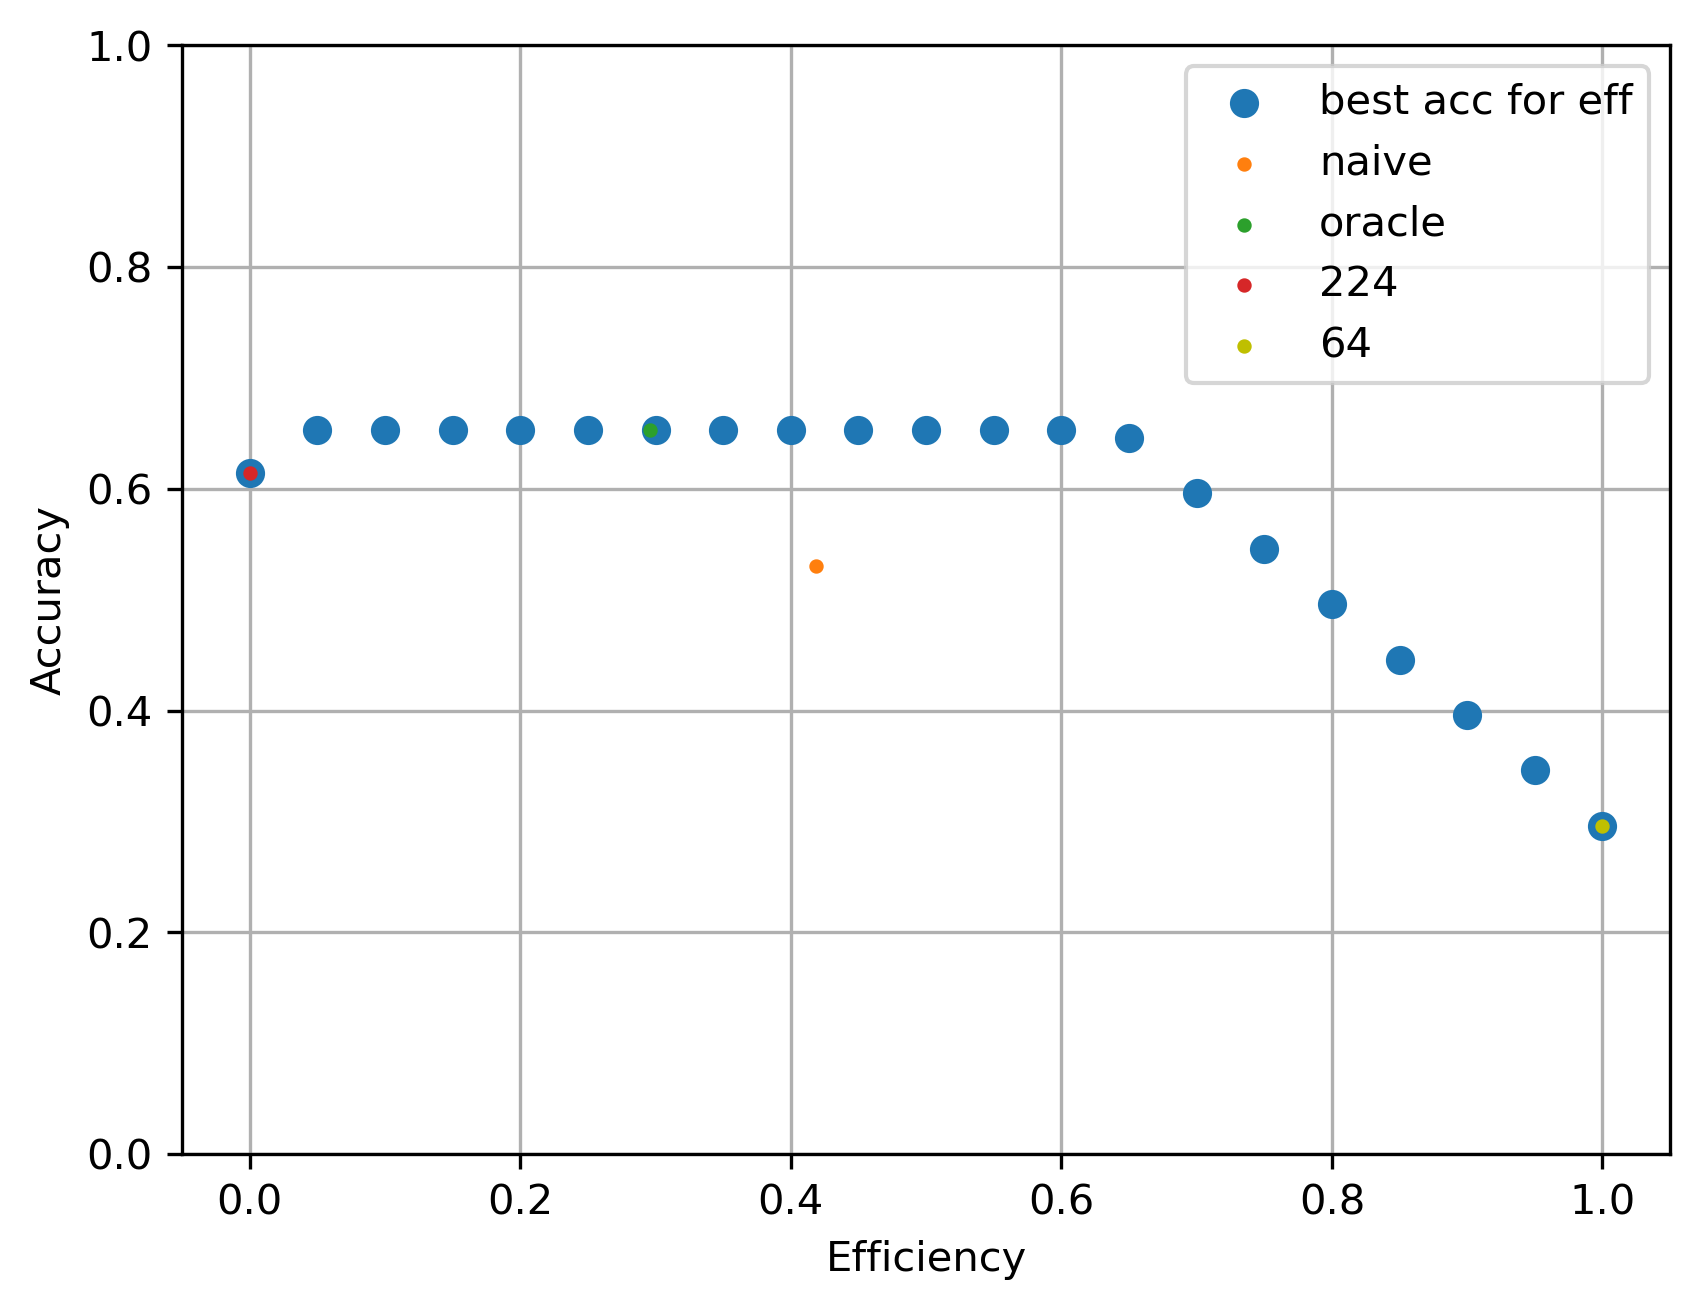

In [359]:
plt.scatter(efficiencies,acc_for_eff,label="best acc for eff")
plt.scatter(corr_naive_efficiency[-1],corr_naive_online_acc[-1],label="naive",s=6)
plt.scatter(corr_oracle_efficiency[-1],corr_oracle_acc[-1],label="oracle",s=6)
plt.scatter(corr_online_efficiency[-1],corr_online_acc[-1],label="224",s=6)
plt.scatter(corr_online_efficiency64[-1],corr_online_acc64[-1],label="64",s=6,c='y')
plt.grid()
plt.legend()
plt.xlabel("Efficiency")
plt.ylabel("Accuracy")
plt.ylim([0,1])

## Changing Models

### corrupt

#### KD and Nearest Class Mean

In [82]:
# KD, freeze layers
import copy
model64_KD = copy.deepcopy(model64)
model64_KD.eval()
# # freeze parameters other than last layer
# for i,c in enumerate(model64_KD.children()):
#     if i == 2:
#         for param in c[0].parameters():
#             param.requires_grad = False
#     else:
#         for param in c.parameters():
#             param.requires_grad = False
# sum(p.numel() for p in model64_KD.parameters() if p.requires_grad)


# # NCM get embedding output
# register forward hook to get embedding output
# activationT = {}
# activationS = {}
# def get_activationT(name):
#     def hook(model, input, output):
#         activationT[name] = output.detach()
#     return hook
# def get_activationS(name):
#     def hook(model, input, output):
#         activationS[name] = output.detach()
#     return hook

# get the activations
model.eval()
# model64.eval()
# model.classifier[0].register_forward_hook(get_activationT('emb'))
# model64.classifier[0].register_forward_hook(get_activationS('emb'))
# class_means = torch.zeros((1000,1280))
# class_counts = torch.ones(1000)
# class_offset_means = torch.zeros((1000,1280))
# class_offset_counts = torch.zeros(1000)

# train_loader64, val_loader64 = load_imagenet64(64,12345)
# # train_loader, val_loader = load_imagenet(64,12345)
# for c_i in range(1000):
#     batch_imgs, batch_labels = next(iter(train_loader64))
#     idxs = (batch_labels == c_i).nonzero()[:15].view(-1)
#     imgs64 = batch_imgs[idxs].to('cuda')
#     # img = train_loader.dataset.dataset[idx][0].unsqueeze(0).to('cuda')
#     pred64 = model64(imgs64) 
#     # pred = model(img) 
#     class_means[c_i] = activationS['emb'].to('cpu').mean(dim=0)
#     # class_offset_means[c_i] = activationT['emb'].to('cpu')-activationS['emb'].to('cpu')

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [83]:
with torch.no_grad():
    print(F.softmax(model64(clean_val_loader64.dataset[0][0].unsqueeze(0).to('cuda'))).max())
    print(F.softmax(model64_KD(clean_val_loader64.dataset[0][0].unsqueeze(0).to('cuda'))).max())

# from torch.utils.data import Subset

# from torch.utils.data.sampler import Sampler

# class CustomOrder(Sampler):
#     def __init__(self, dataset):
#         self.order = torch.randperm(len(dataset),)
        
#     def __iter__(self):
#         return iter(self.order)
    
#     def __len__(self):
#         return len(self.order)

# rand_order = CustomOrder(clean_val_loader.dataset)
# rand_corr_order = torch.randperm(15)

tensor(0.5287, device='cuda:0')
tensor(0.5287, device='cuda:0')


/tmp/ipykernel_352962/1657827570.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(model64(clean_val_loader64.dataset[0][0].unsqueeze(0).to('cuda'))).max())
/tmp/ipykernel_352962/1657827570.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(model64_KD(clean_val_loader64.dataset[0][0].unsqueeze(0).to('cuda'))).max())


Offline

In [85]:
# model64_KD = models.mobilenet_v3_small()
# model64_KD.classifier[0] = torch.nn.Linear(576,1280)
# model64_KD.classifier[3] = torch.nn.Linear(1280,1000)
# model64_KD.load_state_dict(torch.load("best_batch_i162153.pth")['model_state_dict'])
model64_KD.eval()
model64_KD.to('cuda')
opt = torch.optim.SGD(model64_KD.parameters(),lr=0.002)
# tmp_loader = load_imagenetc_val(64,1234,severity=1,sampler=rand_order,corruption="glass_blur")
# tmp_loader64 = load_imagenetc64_val(64,1234,severity=1,sampler=rand_order,corruption="glass_blur")

tmp_val_loaders = []
tmp_val_loaders64 = []
for corr in corruptions:
    tmp_val_loaders.append(load_imagenetc_val(128,1234,corr,severity=1))
    tmp_val_loaders64.append(load_imagenetc64_val(128,1234,corr,severity=1))
correct = []
for idx, ldr in enumerate(tmp_val_loaders):
    dl = iter(tmp_val_loaders[idx])
    dl64 = iter(tmp_val_loaders64[idx])
    print(corruptions[idx])
    for i in range(25):
        img,target = next(dl)
        img64,target64 = next(dl64)
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')

        # do KD
        if i == 0:
            print("train on batch 0")
            # pass
            for id in range(len(img)):
                out = model(img[id].unsqueeze(0))
                pred = out.argmax(dim=1, keepdim=True)
                res = pred.eq(target[id].view_as(pred)).sum().item()

                out64 = model64_KD(img64[id].unsqueeze(0))
                pred64 = out64.argmax(dim=1, keepdim=True)
                res64 = pred64.eq(target64[id].view_as(pred64)).sum().item()
                opt.zero_grad()
                T = 5
                alpha = 0.9
                loss_KD = nn.KLDivLoss()(F.log_softmax(out64/T),
                                        F.softmax(out/T))* (alpha * T * T) + \
                                F.cross_entropy(out64, pred.view(-1)) * (1. - alpha)
                loss_KD.backward()
                opt.step()
        else:
            out = model(img)
            pred = out.argmax(dim=1, keepdim=True)
            res = pred.eq(target.view_as(pred)).sum().item()

            out64 = model64_KD(img64)
            pred64 = out64.argmax(dim=1, keepdim=True)
            res64 = pred64.eq(target64.view_as(pred64)).sum().item()

        # if i == 1:
        #     opt.zero_grad()
        #     T = 5
        #     alpha = 0.9
        #     loss_KD = nn.KLDivLoss()(F.log_softmax(out64/T),
        #                             F.softmax(out/T))* (alpha * T * T) + \
        #                     F.cross_entropy(out64, pred.view(-1)) * (1. - alpha)
        #     loss_KD.backward()
        #     opt.step()

        correct.append(res64/len(target64))

        # print(sum(correct)/len(correct))
print()
    

/tmp/ipykernel_352962/2056817704.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img,target = img.to('cuda'),torch.tensor(target).to('cuda')
/tmp/ipykernel_352962/2056817704.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')
/tmp/ipykernel_352962/2056817704.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_KD = nn.KLDivLoss()(F.log_softmax(out64/T),
/tmp/ipykernel_352962/2056817704.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(out/T))

0.171875
0.09375
0.125
0.15234375
0.178125
0.17447916666666666
0.17410714285714285
0.1796875
0.18055555555555555
0.18125
0.1903409090909091
0.18880208333333334
0.19230769230769232
0.19642857142857142
0.19791666666666666
0.201171875
0.20404411764705882
0.2074652777777778
0.20970394736842105
0.20859375
0.20758928571428573
0.20525568181818182
0.20923913043478262
0.20963541666666666
0.206875
0.20733173076923078
0.21180555555555555
0.21316964285714285
0.21497844827586207
0.21510416666666668
0.2157258064516129
0.21533203125
0.2159090909090909
0.21507352941176472
0.21651785714285715
0.21614583333333334
0.21663851351351351
0.21463815789473684
0.2127403846153846
0.21171875
0.21341463414634146
0.21205357142857142
0.20930232558139536
0.21022727272727273
0.20972222222222223
0.21263586956521738
0.21143617021276595
0.2099609375
0.20982142857142858
0.2090625


In [67]:
# corr baseline
corr_online_acc_KD = []
corr_online_efficiency_KD = []
# corr_online_acc_NCM = []
# corr_online_efficiency_NCM = []
corr_online_ops_KD = []
# corr_online_ops_NCM = []

idxs = []

num_imgs = 0

corr_num_correct_KD = 0
# corr_num_correct_NCM = 0


# corr_num_wrong_decisions_KD = 0
corr_num_choose_small_KD = 0
corr_num_choose_big_KD = 0
# corr_num_wrong_decisions_NCM = 0
# corr_num_choose_small_NCM = 0
# corr_num_choose_big_NCM = 0

# small_right_big_wrong = []
# big_right_small_wrong = []

# corr_overconfident_locations = []
# corr_overconfident_imgs = []
# corr_underconfident_locations = []
# corr_underconfident_imgs = []
transition_points = [1999]
corr_idx = 0
corr_img_count = 0

opt = torch.optim.SGD(model64_KD.parameters(),lr=0.002)
corr_st = False
for sample_idx in tqdm(rand_order):
    # corruptions start after the first 500 images
    if num_imgs-1 > 1999:
        # each corruption lasts 3300 images
        if corr_img_count == 3200:
            corr_st = True
            corr_idx += 1
            corr_img_count = 0
            transition_points.append(num_imgs)
        # get the image at the specified index
        img,target = corr_val_loaders[rand_corr_order[corr_idx]].dataset[sample_idx]
        img64,target64 = corr_val_loaders64[rand_corr_order[corr_idx]].dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')
        corr_img_count += 1
    else:
        img,target = clean_val_loader.dataset[sample_idx]
        img64,target64 = clean_val_loader64.dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')

    num_imgs += 1
    
    # get the prediction of small model
    out64 = model64_KD(img64.unsqueeze(0))
    pred64 = out64.argmax(dim=1).item()
    res64 = (pred64 == target64.item())

    # get the embedding
    # out64_dummy = model64(img64.unsqueeze(0))
    # model64_emb = activationS['emb'].to('cpu')

    # get class with the closest mean (using student emb)
    # ncs = (((class_means+class_offset_means)-model64_emb).pow(2).sum(dim=1).sqrt()).argmin()
    # use teach 25% of the time
    # if torch.rand(1) > 0.75 and num_imgs-1 > 1999:
    #     corr_num_choose_big_NCM += 1
    #     with torch.no_grad():
    #         # get teacher pred and emb
    #         nct = model(img.unsqueeze(0)).argmax(dim=1).item()
    #         # model_emb = activationT['emb'].to('cpu')
    #         class_counts[nct] += 1
    #         class_offset_counts[nct] += 1
    #         # update class mean normally
    #         class_offset_means[nct,:] = (class_offset_means[nct,:] + (model64_emb - class_means[nct,:]))/class_offset_counts[nct]
    #         class_means[nct,:] = (class_means[nct,:] + model64_emb)/class_counts[nct] #+ 0.95*model_emb
            
    #         corr_num_correct_NCM += (nct == target64.item())
    #     if (ncs == target64.item()):
    #         corr_num_wrong_decisions_NCM += 1
    # else:
    #     corr_num_choose_small_NCM += 1
    #     corr_num_correct_NCM += (ncs == target64.item())
    #     # otherwise use small model ncm
    #     class_counts[ncs] += 1
    #     class_means[ncs,:] = (class_means[ncs,:] + model64_emb)/class_counts[ncs]
    
    # corr_online_efficiency.append(0)
    # corr_online_efficiency64.append(1)
    # corr_online_ops.append(234)
    # corr_online_ops64.append(22)

    # naive strategy, if less than 50% confident, use big model
    # conf64 = torch.nn.Softmax()(out64).max().item() 
    # print(conf64)
    # if conf64 < 0.50:
    if corr_img_count >= 1 and corr_img_count <= 64:#torch.rand(1) > 0.9 and num_imgs-1 > 1999:
        with torch.no_grad():
            out = model(img.unsqueeze(0))
        pred = out.argmax(dim=1).item()
        res = (pred == target.item())
        corr_num_correct_KD += res64

        # do KD
        opt.zero_grad()
        T = 5
        alpha = 0.9
        loss_KD = nn.KLDivLoss()(F.log_softmax(out64/T, dim=1),
                                F.softmax(out/T, dim=1))* (alpha * T * T) + \
                        F.cross_entropy(out64, torch.tensor(pred).unsqueeze(0).to('cuda')) * (1. - alpha)
        loss_KD.backward()
        opt.step()

        # get the T embedding
        # model_emb = activationT['emb'].to('cpu')
        # class_counts[pred] += 1
        # class_means[pred,:] = 0.8*(class_means[pred,:] + model64_emb)/class_counts[pred] + 0.2*model_emb


        corr_num_choose_big_KD += 1
        # if was underconfident
        # if res64:
        #     corr_num_wrong_decisions_KD += 1
    else:
        # class_counts[nc] += 1
        # class_means[nc,:] = (class_means[pred,:] + model64_emb)/class_counts[nc]
        # corr_num_correct_NCM += (nc == target64.item())
        corr_num_correct_KD += res64
        corr_num_choose_small_KD += 1
        # if was overconfident
        # if not res64 and res:
        #     corr_num_wrong_decisions_KD += 1
    corr_online_acc_KD.append(corr_num_correct_KD/num_imgs)
    corr_online_efficiency_KD.append(corr_num_choose_small_KD/num_imgs)
    corr_online_ops_KD.append((corr_num_choose_small_KD*22+corr_num_choose_big_KD*(234+22+66))/num_imgs)

    # corr_online_acc_NCM.append(corr_num_correct_NCM/num_imgs)
    # corr_online_efficiency_NCM.append(corr_num_choose_small_NCM/num_imgs)
    # corr_online_ops_NCM.append((corr_num_choose_small_NCM*22+corr_num_choose_big_NCM*234)/num_imgs)
    idxs.append(num_imgs)

  4%|▍         | 1996/50000 [00:20<08:00, 99.86it/s] /home/gc28692/anaconda3/envs/cl/lib/python3.9/site-packages/torch/nn/functional.py:2916: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
100%|██████████| 50000/50000 [05:49<00:00, 142.88it/s]


(0.0, 1.0)

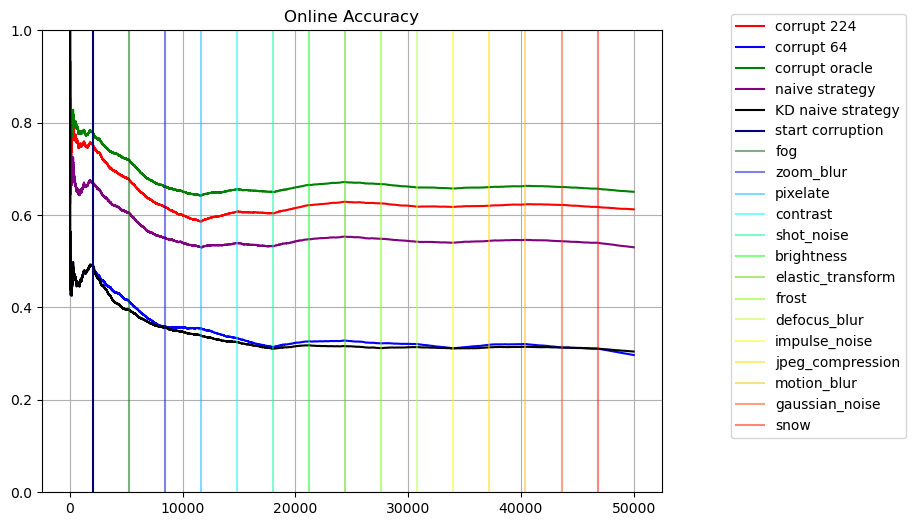

In [68]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,corr_online_acc,label='corrupt 224',color='red')
ax1.plot(idxs,corr_online_acc64,label='corrupt 64',color='blue')
ax1.plot(idxs,corr_oracle_acc,label='corrupt oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,corr_naive_online_acc,label='naive strategy',color='purple')
ax1.plot(idxs,corr_online_acc_KD,label='KD naive strategy',color='black')
# ax1.plot(idxs,corr_online_acc_NCM,label='NCM naive strategy',color='orange')
ax1.axvline(x = transition_points[0], color = 'orange', label = 'start corruption')
for i,x in enumerate(transition_points[1:]):
    plt.axvline(x =x, label = corruptions[rand_corr_order[i]],alpha=0.5)
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines[5:]):
    j.set_color(colors[i])

# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
# ax1.set_ylabel("Online Accuracy")
# ax2.set_ylabel("# overconfident images")
# ax1.set_xlabel("Image Index")
plt.grid()
plt.title("Online Accuracy")
plt.ylim([0,1])

(-0.1, 1.1)

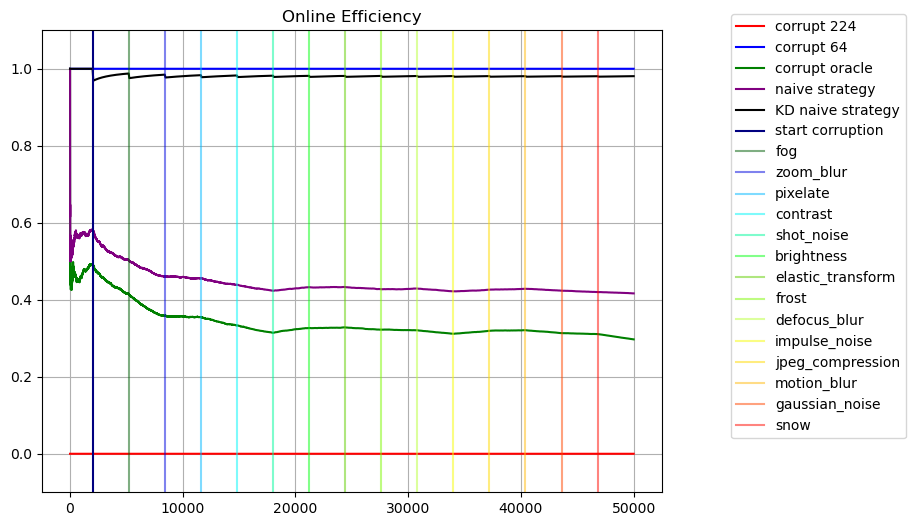

In [69]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,corr_online_efficiency,label='corrupt 224',color='red')
ax1.plot(idxs,corr_online_efficiency64,label='corrupt 64',color='blue')
ax1.plot(idxs,corr_oracle_efficiency,label='corrupt oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,corr_naive_efficiency,label='naive strategy',color='purple')
ax1.plot(idxs,corr_online_efficiency_KD,label='KD naive strategy',color='black')
# ax1.plot(idxs,corr_online_efficiency_NCM,label='NCM naive strategy',color='orange')
ax1.axvline(x = transition_points[0], color = 'orange', label = 'start corruption')
for i,x in enumerate(transition_points[1:]):
    plt.axvline(x =x, label = corruptions[rand_corr_order[i]],alpha=0.5)
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines[5:]):
    j.set_color(colors[i])

# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
# ax1.set_ylabel("Online Accuracy")
# ax2.set_ylabel("# overconfident images")
# ax1.set_xlabel("Image Index")
plt.grid()
plt.title("Online Efficiency")
plt.ylim([-0.1,1.1])

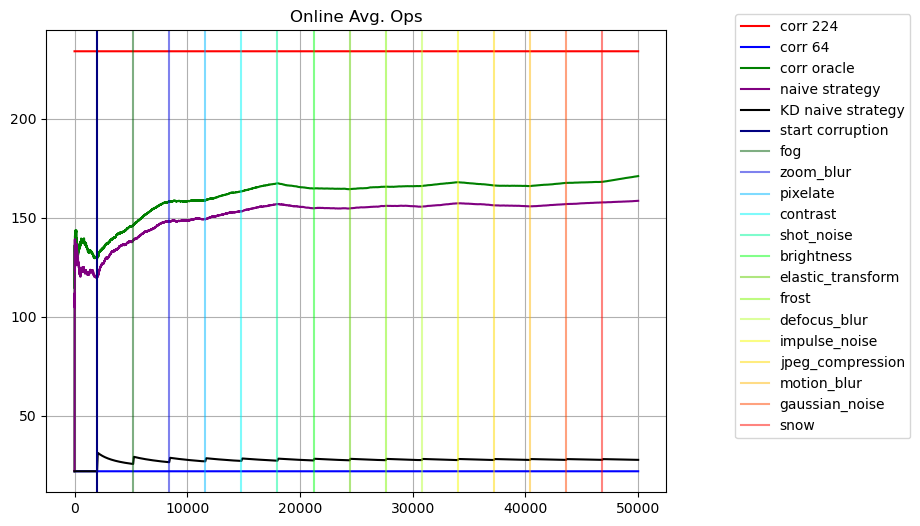

In [70]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,corr_online_ops,label='corr 224',color='red')
ax1.plot(idxs,corr_online_ops64,label='corr 64',color='blue')
ax1.plot(idxs,corr_oracle_ops,label='corr oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,corr_naive_ops,label='naive strategy',color='purple')
ax1.plot(idxs,corr_online_ops_KD,label='KD naive strategy',color='black')
plt.title("Online Avg. Ops")
ax1.axvline(x = transition_points[0], color = 'orange', label = 'start corruption')
for i,x in enumerate(transition_points[1:]):
    plt.axvline(x =x, label = corruptions[rand_corr_order[i]],alpha=0.5)
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines[5:]):
    j.set_color(colors[i])
# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
# ax1.set_ylabel("Online Accuracy")
# ax2.set_ylabel("# overconfident images")
# ax1.set_xlabel("Image Index")
plt.grid()

In [356]:
print(clean_naive_num_choose_small)
# print(clean_naive_num_choose_big)
print(clean_oracle_num_choose_small)
# print(clean_oracle_num_choose_big)
print("=======")
print(corr_naive_num_choose_small)
# print(corr_naive_num_choose_big)
print(corr_oracle_num_choose_small)
# print(corr_oracle_num_choose_big)
print(corr_num_choose_small_KD)

27752
23822
20942
14804
20415


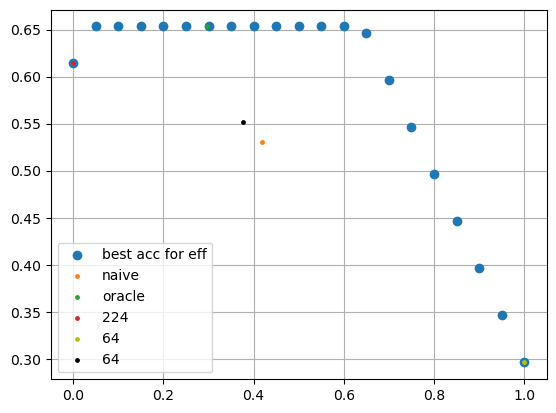

In [247]:
plt.scatter(efficiencies,acc_for_eff,label="best acc for eff")
plt.scatter(corr_naive_efficiency[-1],corr_naive_online_acc[-1],label="naive",s=6)
plt.scatter(corr_oracle_efficiency[-1],corr_oracle_acc[-1],label="oracle",s=6)
plt.scatter(corr_online_efficiency[-1],corr_online_acc[-1],label="224",s=6)
plt.scatter(corr_online_efficiency64[-1],corr_online_acc64[-1],label="64",s=6,c='y')
plt.scatter(corr_online_efficiency_KD[-1],corr_online_acc_KD[-1],label="64",s=6,c='k')
plt.grid()
plt.legend()